In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy import fft
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
import io

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print("=== ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ ===")
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк:")
display(df.head())
print("\nИнформация о типах данных:")
print(df.info())
print("\nСтатистическое описание:")
display(df.describe())
print("\nПропущенные значения:")
print(df.isnull().sum())

Saving salesweekly.csv to salesweekly.csv
=== ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ ===
Размер датасета: (302, 9)

Первые 5 строк:


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   302 non-null    object 
 1   M01AB   302 non-null    float64
 2   M01AE   302 non-null    float64
 3   N02BA   302 non-null    float64
 4   N02BE   302 non-null    float64
 5   N05B    302 non-null    float64
 6   N05C    302 non-null    float64
 7   R03     302 non-null    float64
 8   R06     302 non-null    float64
dtypes: float64(8), object(1)
memory usage: 21.4+ KB
None

Статистическое описание:


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,35.102441,27.167611,27.060295,208.627161,61.740853,4.138935,38.439811,20.224561
std,8.617106,7.043491,8.086458,76.069221,22.436970,3.129265,22.900873,11.381464
min,7.670000,6.237000,3.500000,86.250000,18.000000,0.000000,2.000000,1.000000
25%,29.387500,22.387500,21.300000,149.300000,47.000000,2.000000,21.000000,11.475000
50%,34.565000,26.789500,26.500000,198.300000,57.000000,3.979167,35.000000,17.500000
75%,40.175000,31.046500,32.475000,252.471500,71.000000,6.000000,51.000000,26.000000
max,65.330000,53.571000,60.125000,546.899000,154.000000,17.000000,131.000000,65.000000



Пропущенные значения:
datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64


In [ ]:
# Препроцессинг и подготовка временных рядов
# Преобразуем дату
df['datum'] = pd.to_datetime(df['datum'], format='%m/%d/%Y')
df = df.sort_values('datum').reset_index(drop=True)

# Проверяем пропуски в датах
date_range = pd.date_range(start=df['datum'].min(), end=df['datum'].max(), freq='W')
print(f"Полный диапазон недель: {len(date_range)}")
print(f"Фактическое количество записей: {len(df)}")

# ATC категории
atc_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Заполняем пропуски в числовых колонках
for column in atc_columns:
    df[column].fillna(df[column].median(), inplace=True)

print("Препроцессинг завершен")
print(f"Диапазон данных: {df['datum'].min()} до {df['datum'].max()}")

Полный диапазон недель: 302
Фактическое количество записей: 302
Препроцессинг завершен
Диапазон данных: 2014-01-05 00:00:00 до 2019-10-13 00:00:00


=== ДЕТАЛЬНЫЙ EDA АНАЛИЗ ===


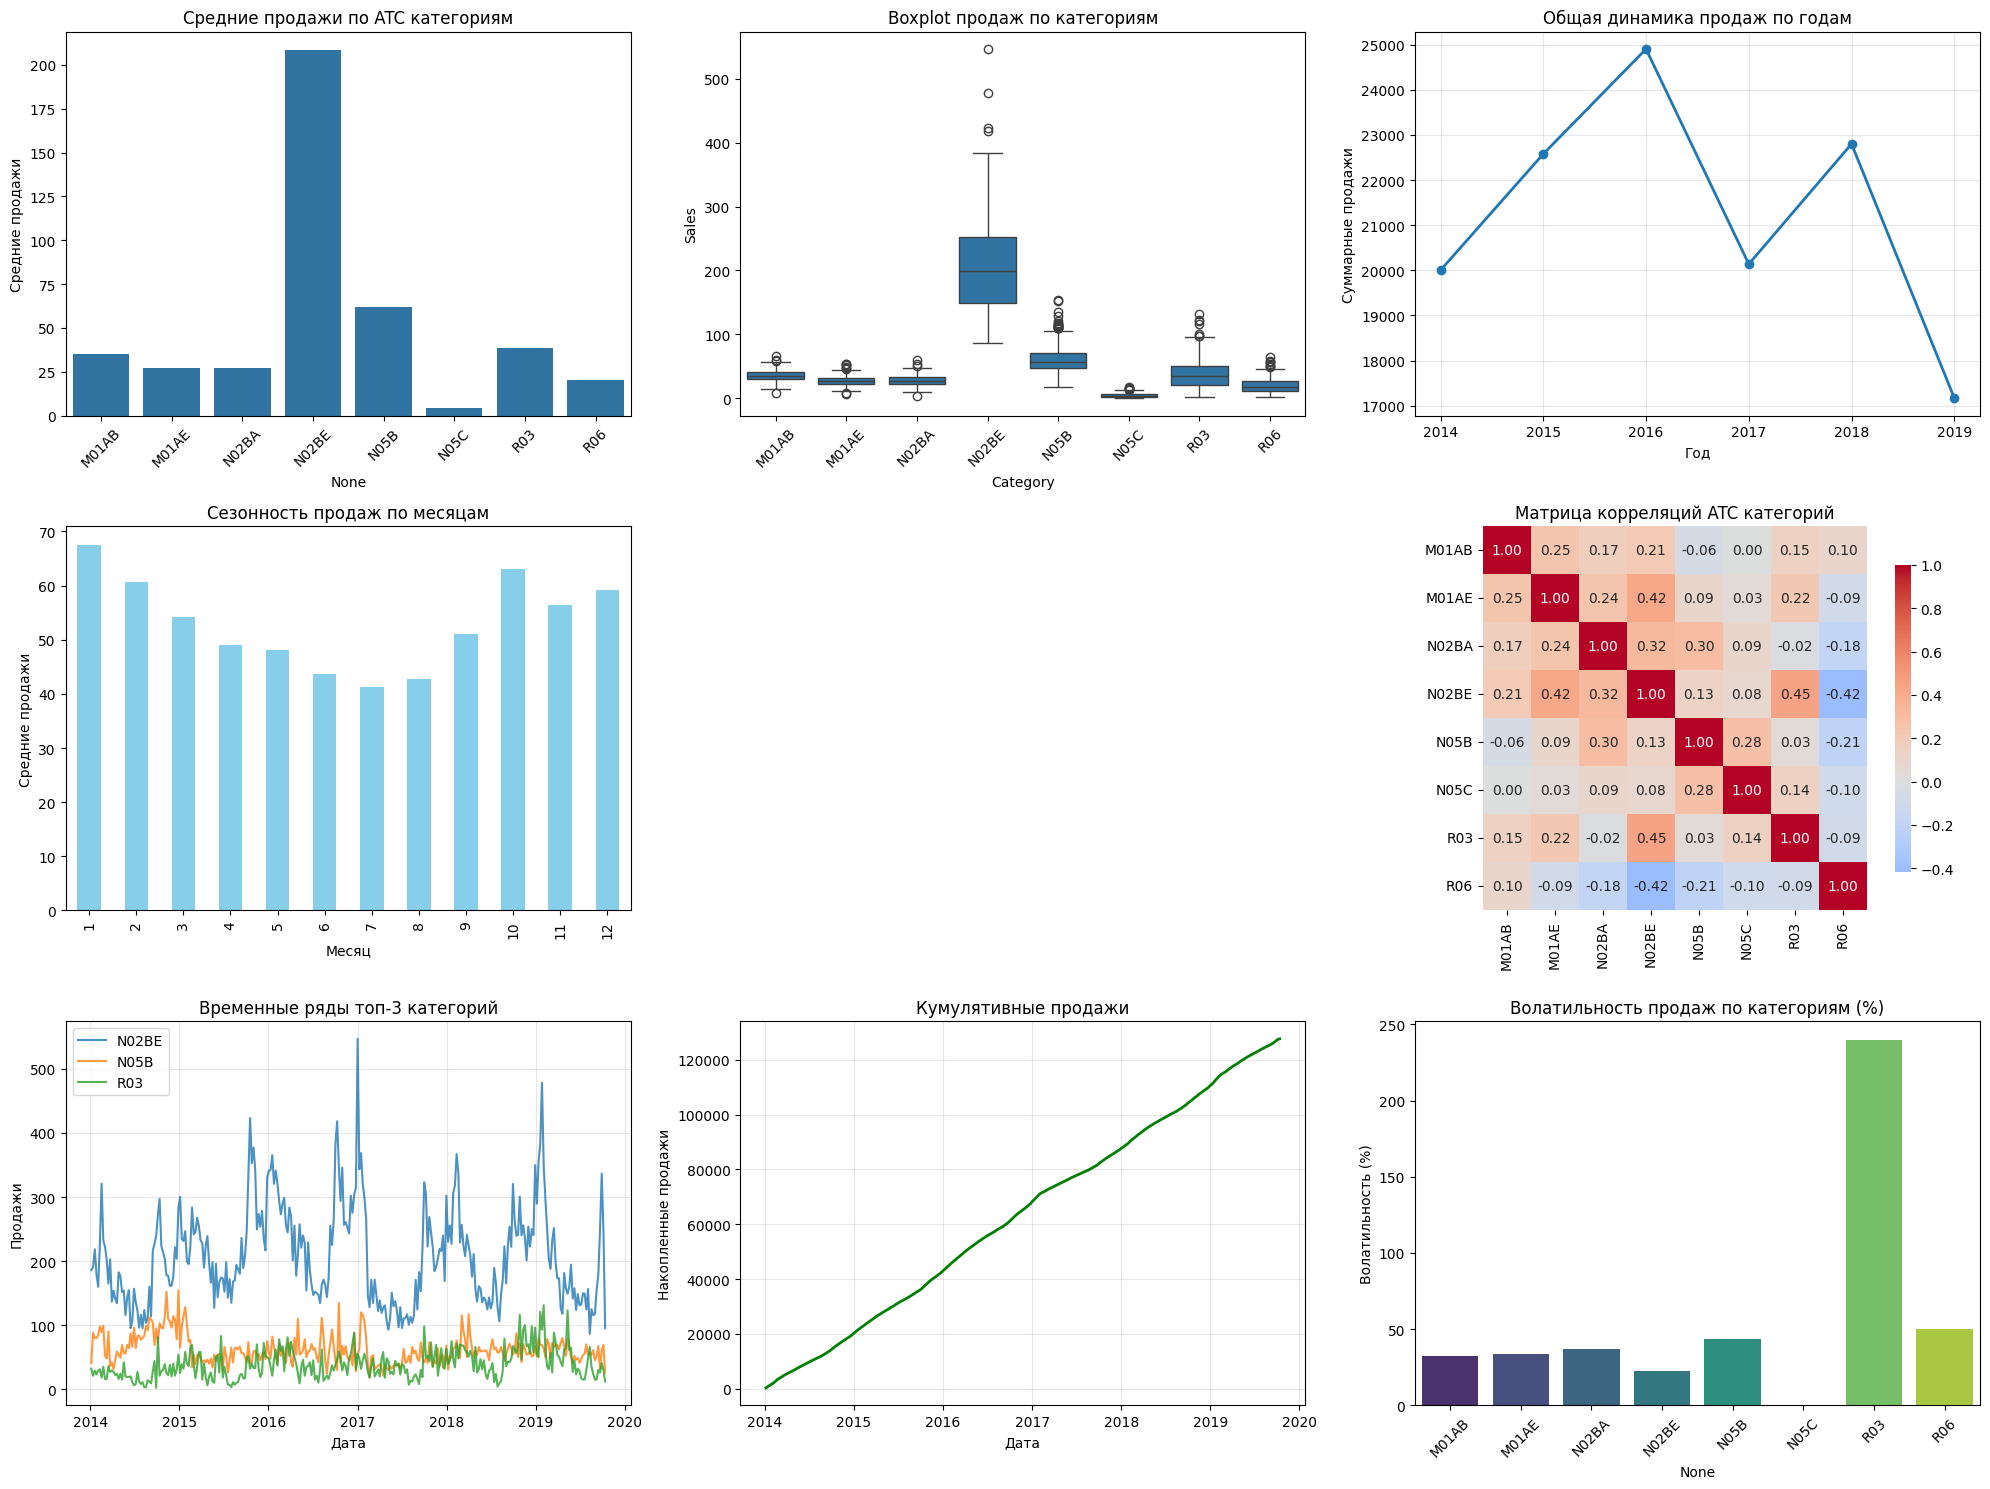

In [ ]:
# ДЕТАЛЬНЫЙ EDA АНАЛИЗ
print("=== ДЕТАЛЬНЫЙ EDA АНАЛИЗ ===")
import seaborn as sns

# Создаем подграфики
fig = plt.figure(figsize=(20, 15))

# 1. Распределение продаж по категориям (гистограммы)
plt.subplot(3, 3, 1)
category_means = df[atc_columns].mean()
sns.barplot(x=category_means.index, y=category_means.values)
plt.title('Средние продажи по ATC категориям')
plt.xticks(rotation=45)
plt.ylabel('Средние продажи')

# 2. Boxplot для выявления выбросов
plt.subplot(3, 3, 2)
df_melted = df[atc_columns].melt(var_name='Category', value_name='Sales')
sns.boxplot(data=df_melted, x='Category', y='Sales')
plt.title('Boxplot продаж по категориям')
plt.xticks(rotation=45)

# 3. Динамика продаж по годам
plt.subplot(3, 3, 3)
df['year'] = df['datum'].dt.year
yearly_sales = df.groupby('year')[atc_columns].sum().sum(axis=1)
yearly_sales.plot(kind='line', marker='o', linewidth=2)
plt.title('Общая динамика продаж по годам')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи')
plt.grid(True, alpha=0.3)

# 4. Сезонность по месяцам
plt.subplot(3, 3, 4)
df['month'] = df['datum'].dt.month
monthly_pattern = df.groupby('month')[atc_columns].mean().mean(axis=1)
monthly_pattern.plot(kind='bar', color='skyblue')
plt.title('Сезонность продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средние продажи')


# 5. Heatmap корреляций между категориями
plt.subplot(3, 3, 6)
correlation_matrix = df[atc_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Матрица корреляций ATC категорий')

# 6. Временной ряд для топ-3 категорий
plt.subplot(3, 3, 7)
top_categories = df[atc_columns].sum().nlargest(3).index
for category in top_categories:
    plt.plot(df['datum'], df[category], label=category, linewidth=1.5, alpha=0.8)
plt.title('Временные ряды топ-3 категорий')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Кумулятивные продажи
plt.subplot(3, 3, 8)
cumulative_sales = df[atc_columns].cumsum().sum(axis=1)
plt.plot(df['datum'], cumulative_sales, linewidth=2, color='green')
plt.title('Кумулятивные продажи')
plt.xlabel('Дата')
plt.ylabel('Накопленные продажи')
plt.grid(True, alpha=0.3)

# 8. Волатильность продаж
plt.subplot(3, 3, 9)
volatility = df[atc_columns].pct_change().std() * 100
sns.barplot(x=volatility.index, y=volatility.values, palette='viridis')
plt.title('Волатильность продаж по категориям (%)')
plt.xticks(rotation=45)
plt.ylabel('Волатильность (%)')

plt.tight_layout()
plt.show()

In [ ]:
print("=== СТАТИСТИЧЕСКАЯ АНАЛИТИКА ===")

# Детальная статистика
stats_summary = df[atc_columns].describe().T
stats_summary['cv'] = stats_summary['std'] / stats_summary['mean']  # Коэффициент вариации
stats_summary['skewness'] = df[atc_columns].skew()
stats_summary['kurtosis'] = df[atc_columns].kurtosis()

print("Детальная статистика по категориям:")
display(stats_summary)

# Анализ трендов
print("\nАнализ трендов (линейная регрессия):")
from sklearn.linear_model import LinearRegression

trend_analysis = {}
for column in atc_columns:
    X = np.arange(len(df)).reshape(-1, 1)
    y = df[column].values
    model = LinearRegression()
    model.fit(X, y)
    trend_slope = model.coef_[0]
    trend_strength = model.score(X, y)
    trend_analysis[column] = {
        'slope': trend_slope,
        'r_squared': trend_strength,
        'trend': 'Восходящий' if trend_slope > 0 else 'Нисходящий' if trend_slope < 0 else 'Стабильный'
    }

trend_df = pd.DataFrame(trend_analysis).T
print("Анализ линейных трендов:")
display(trend_df)

=== СТАТИСТИЧЕСКАЯ АНАЛИТИКА ===
Детальная статистика по категориям:


,count,mean,std,min,25%,50%,75%,max,cv,skewness,kurtosis
M01AB,302.0,35.102441,8.617106,7.670,29.3875,34.565000,40.1750,65.330,0.245485,0.322495,0.473087
M01AE,302.0,27.167611,7.043491,6.237,22.3875,26.789500,31.0465,53.571,0.259261,0.637470,1.543666
N02BA,302.0,27.060295,8.086458,3.500,21.3000,26.500000,32.4750,60.125,0.298831,0.438507,0.729999
N02BE,302.0,208.627161,76.069221,86.250,149.3000,198.300000,252.4715,546.899,0.364618,0.869151,0.974391
N05B,302.0,61.740853,22.436970,18.000,47.0000,57.000000,71.0000,154.000,0.363406,1.127520,1.712828
N05C,302.0,4.138935,3.129265,0.000,2.0000,3.979167,6.0000,17.000,0.756056,1.115745,1.841351
R03,302.0,38.439811,22.900873,2.000,21.0000,35.000000,51.0000,131.000,0.595759,1.059048,1.501677
R06,302.0,20.224561,11.381464,1.000,11.4750,17.500000,26.0000,65.000,0.562755,1.073355,1.011189



Анализ трендов (линейная регрессия):
Анализ линейных трендов:


,slope,r_squared,trend
M01AB,0.021079,0.045628,Восходящий
M01AE,0.000567,0.000049,Восходящий
N02BA,-0.047729,0.265657,Нисходящий
N02BE,-0.000294,0.0,Нисходящий
N05B,-0.063018,0.060155,Нисходящий
N05C,0.000484,0.000183,Восходящий
R03,0.092558,0.124564,Восходящий
R06,0.030598,0.055114,Восходящий


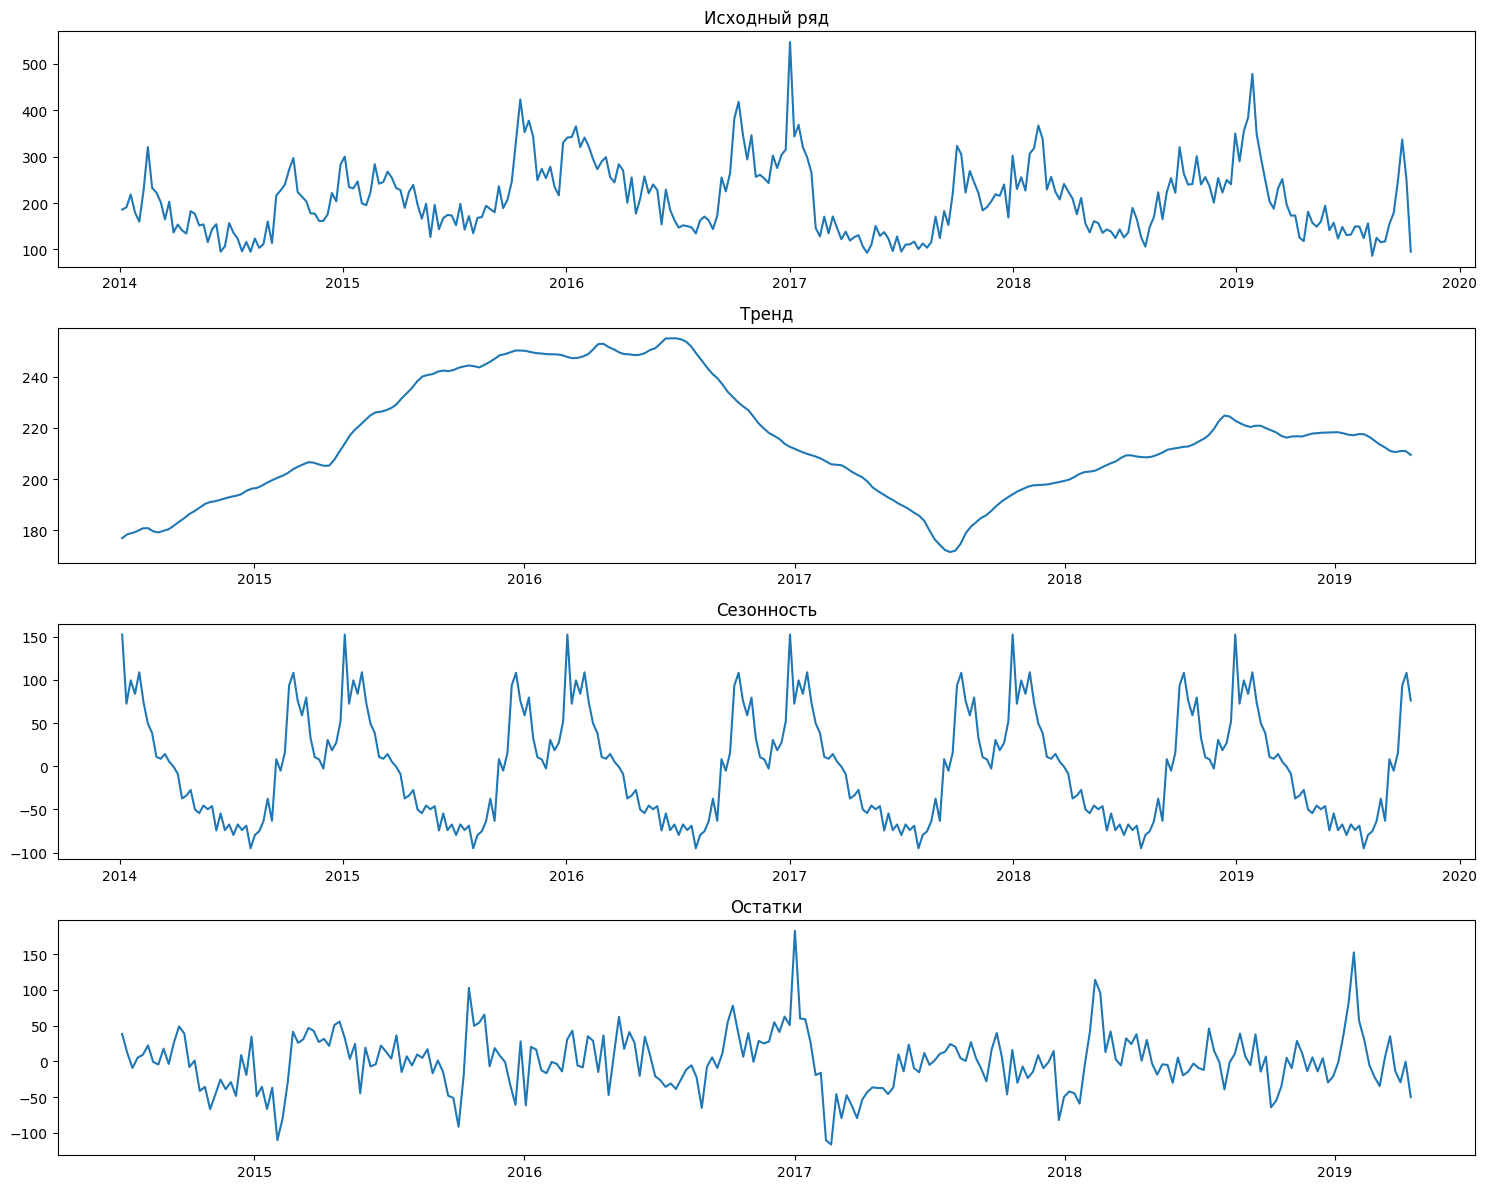

In [ ]:
# Анализ сезонности и трендов
from statsmodels.tsa.seasonal import seasonal_decompose

# Декомпозиция для выбранной категории
category = 'N02BE'  # Выбираем категорию с выраженной сезонностью

if len(df) >= 104:  # Минимум 2 года для недельных данных
    decomposition = seasonal_decompose(df[category].values, model='additive', period=52)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    axes[0].plot(df['datum'], decomposition.observed)
    axes[0].set_title('Исходный ряд')

    axes[1].plot(df['datum'], decomposition.trend)
    axes[1].set_title('Тренд')

    axes[2].plot(df['datum'], decomposition.seasonal)
    axes[2].set_title('Сезонность')

    axes[3].plot(df['datum'], decomposition.resid)
    axes[3].set_title('Остатки')

    plt.tight_layout()
    plt.show()

In [ ]:
print("=== 3D ВИЗУАЛИЗАЦИЯ ===")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 3D scatter plot по топ-3 категориям
if len(atc_columns) >= 3:
    fig = px.scatter_3d(df,
                       x=atc_columns[0],
                       y=atc_columns[1],
                       z=atc_columns[2],
                       color='year',
                       title='3D визуализация продаж по топ-3 категориям',
                       opacity=0.7,
                       size_max=10)
    fig.show()

# Интерактивный временной ряд
fig = go.Figure()
for column in atc_columns[:4]:  # Показываем первые 4 категории
    fig.add_trace(go.Scatter(x=df['datum'], y=df[column],
                            mode='lines',
                            name=column,
                            opacity=0.7))

fig.update_layout(title='Интерактивные временные ряды продаж',
                  xaxis_title='Дата',
                  yaxis_title='Продажи',
                  hovermode='x unified')
fig.show()

=== 3D ВИЗУАЛИЗАЦИЯ ===


In [ ]:
# Тест на стационарность
print("=== ТЕСТ ДИКИ-ФУЛЛЕРА НА СТАЦИОНАРНОСТЬ ===")

for column in atc_columns:
    result = adfuller(df[column].dropna())
    print(f"{column}: ADF Statistic = {result[0]:.6f}, p-value = {result[1]:.6f}")
    if result[1] <= 0.05:
        print(f"  Ряд {column} стационарен (отвергаем H0)")
    else:
        print(f"  Ряд {column} нестационарен (не отвергаем H0)")

=== ТЕСТ ДИКИ-ФУЛЛЕРА НА СТАЦИОНАРНОСТЬ ===
M01AB: ADF Statistic = -3.628724, p-value = 0.005235
  Ряд M01AB стационарен (отвергаем H0)
M01AE: ADF Statistic = -8.739383, p-value = 0.000000
  Ряд M01AE стационарен (отвергаем H0)
N02BA: ADF Statistic = -1.721399, p-value = 0.420122
  Ряд N02BA нестационарен (не отвергаем H0)
N02BE: ADF Statistic = -4.370604, p-value = 0.000334
  Ряд N02BE стационарен (отвергаем H0)
N05B: ADF Statistic = -3.598815, p-value = 0.005784
  Ряд N05B стационарен (отвергаем H0)
N05C: ADF Statistic = -15.000535, p-value = 0.000000
  Ряд N05C стационарен (отвергаем H0)
R03: ADF Statistic = -3.417632, p-value = 0.010372
  Ряд R03 стационарен (отвергаем H0)
R06: ADF Statistic = -5.028058, p-value = 0.000020
  Ряд R06 стационарен (отвергаем H0)


Train size: 241
Test size: 61


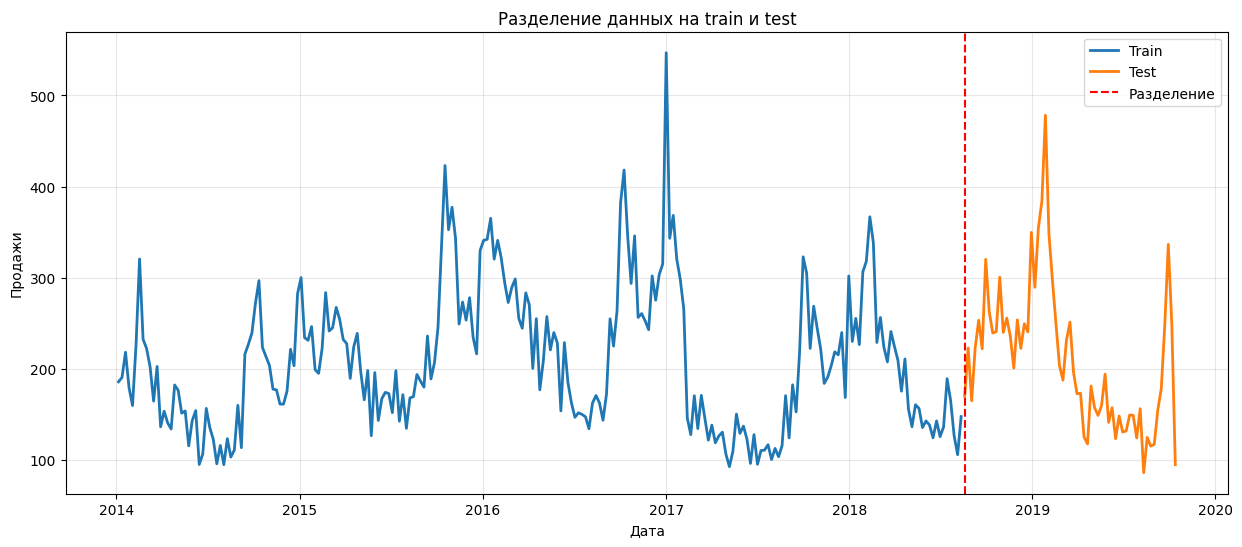

In [ ]:
# Подготовка данных для моделей прогнозирования
# Выбираем одну категорию для прогнозирования
target_column = 'N02BE'
target_series = df[target_column].values
dates = df['datum']

# Разделение на train/test
split_idx = int(len(target_series) * 0.8)
train_data = target_series[:split_idx]
test_data = target_series[split_idx:]
train_dates = dates[:split_idx]
test_dates = dates[split_idx:]

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

# Визуализация разделения
plt.figure(figsize=(15, 6))
plt.plot(train_dates, train_data, label='Train', linewidth=2)
plt.plot(test_dates, test_data, label='Test', linewidth=2)
plt.axvline(x=test_dates.iloc[0], color='red', linestyle='--', label='Разделение')
plt.title('Разделение данных на train и test')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

=== МОДЕЛЬ ARIMA ===


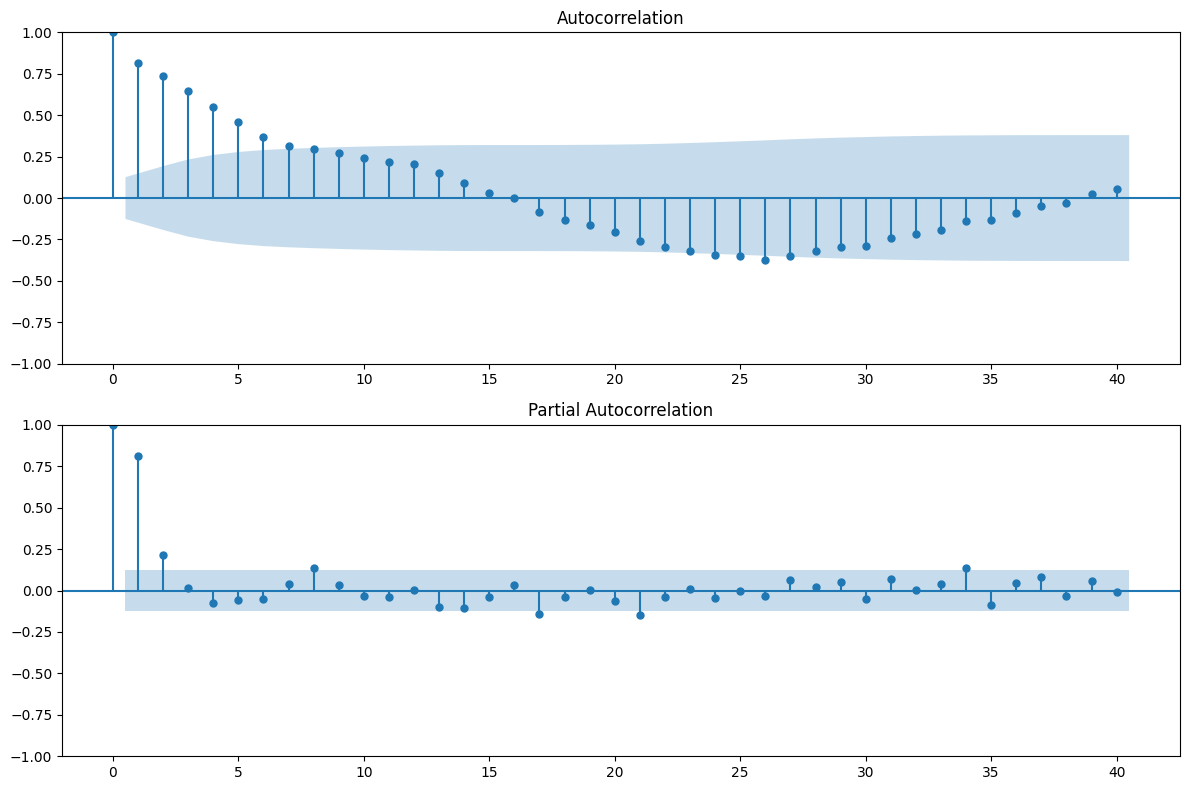

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  241
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1246.913
Date:                Thu, 16 Oct 2025   AIC                           2503.827
Time:                        11:44:41   BIC                           2521.230
Sample:                             0   HQIC                          2510.839
                                - 241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3788      0.320      1.183      0.237      -0.249       1.007
ar.L2         -0.3665      0.199     -1.837      0.066      -0.757       0.024
ma.L1         -0.6744      0.321     -2.103      0.0

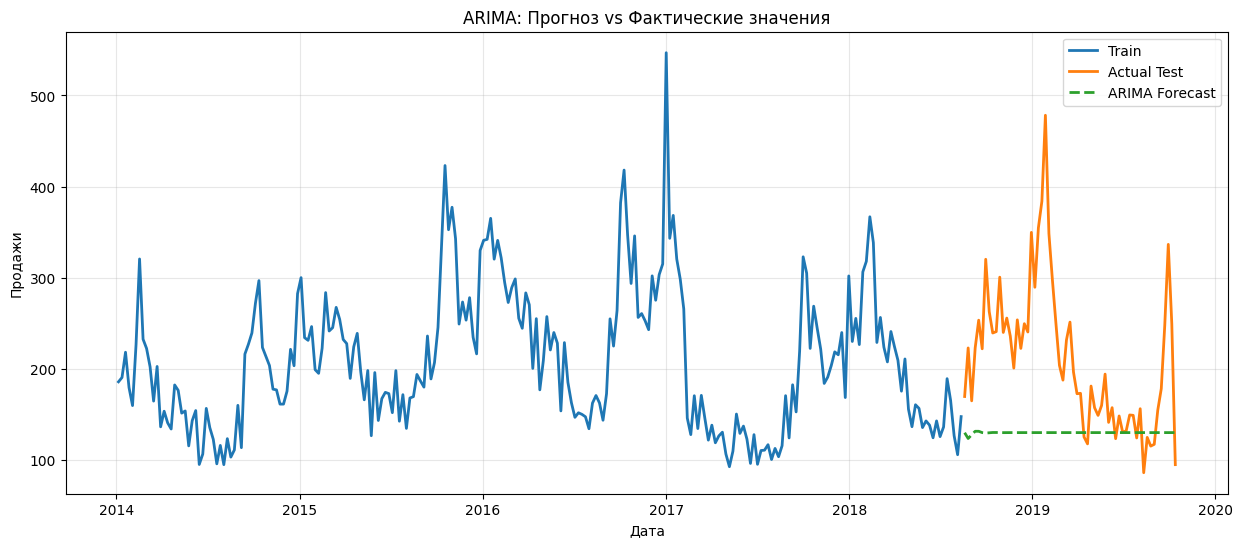

ARIMA Метрики:
MAE: 85.9452
RMSE: 112.8049
R²: -1.0804


In [ ]:
# МОДЕЛЬ 1: ARIMA
print("=== МОДЕЛЬ ARIMA ===")

# ACF и PACF для подбора параметров
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_data, ax=ax1, lags=40)
plot_pacf(train_data, ax=ax2, lags=40)
plt.tight_layout()
plt.show()

# Подбор параметров ARIMA
try:
    arima_model = ARIMA(train_data, order=(2,1,2))
    arima_fit = arima_model.fit()
    print(arima_fit.summary())

    # Прогноз
    arima_forecast = arima_fit.forecast(steps=len(test_data))

    # Визуализация
    plt.figure(figsize=(15, 6))
    plt.plot(train_dates, train_data, label='Train', linewidth=2)
    plt.plot(test_dates, test_data, label='Actual Test', linewidth=2)
    plt.plot(test_dates, arima_forecast, label='ARIMA Forecast', linewidth=2, linestyle='--')
    plt.title('ARIMA: Прогноз vs Фактические значения')
    plt.xlabel('Дата')
    plt.ylabel('Продажи')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Метрики
    arima_mae = mean_absolute_error(test_data, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
    arima_r2 = r2_score(test_data, arima_forecast)

    print(f"ARIMA Метрики:")
    print(f"MAE: {arima_mae:.4f}")
    print(f"RMSE: {arima_rmse:.4f}")
    print(f"R²: {arima_r2:.4f}")

except Exception as e:
    print(f"Ошибка ARIMA: {e}")
    arima_forecast = None

=== МОДЕЛЬ SARIMA ===
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -990.641
Date:                            Thu, 16 Oct 2025   AIC                           1991.281
Time:                                    11:46:17   BIC                           2007.464
Sample:                                         0   HQIC                          1997.838
                                            - 241                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4809      0.088      5.448      0.000       0.308       0.654
ma.L1        

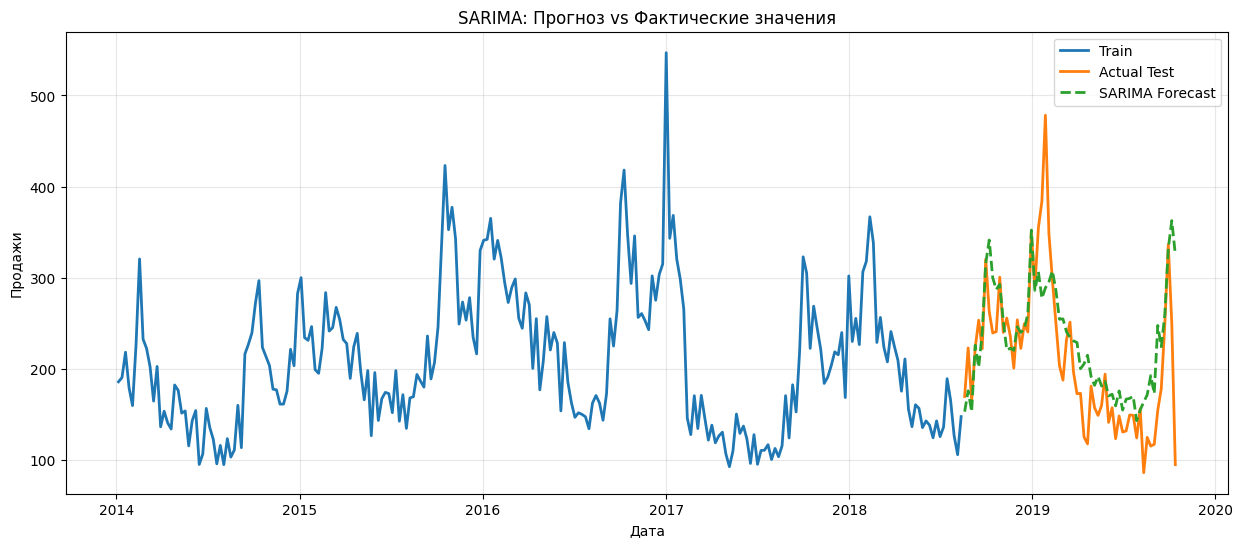

SARIMA Метрики:
MAE: 40.1880
RMSE: 58.0734
R²: 0.4486


In [ ]:
# МОДЕЛЬ 2: SARIMA
print("=== МОДЕЛЬ SARIMA ===")

try:
    sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,52))
    sarima_fit = sarima_model.fit(disp=False)
    print(sarima_fit.summary())

    # Прогноз
    sarima_forecast = sarima_fit.forecast(steps=len(test_data))

    # Визуализация
    plt.figure(figsize=(15, 6))
    plt.plot(train_dates, train_data, label='Train', linewidth=2)
    plt.plot(test_dates, test_data, label='Actual Test', linewidth=2)
    plt.plot(test_dates, sarima_forecast, label='SARIMA Forecast', linewidth=2, linestyle='--')
    plt.title('SARIMA: Прогноз vs Фактические значения')
    plt.xlabel('Дата')
    plt.ylabel('Продажи')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Метрики
    sarima_mae = mean_absolute_error(test_data, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))
    sarima_r2 = r2_score(test_data, sarima_forecast)

    print(f"SARIMA Метрики:")
    print(f"MAE: {sarima_mae:.4f}")
    print(f"RMSE: {sarima_rmse:.4f}")
    print(f"R²: {sarima_r2:.4f}")

except Exception as e:
    print(f"Ошибка SARIMA: {e}")
    sarima_forecast = None

=== ЭКСПОНЕНЦИАЛЬНОЕ СГЛАЖИВАНИЕ ===


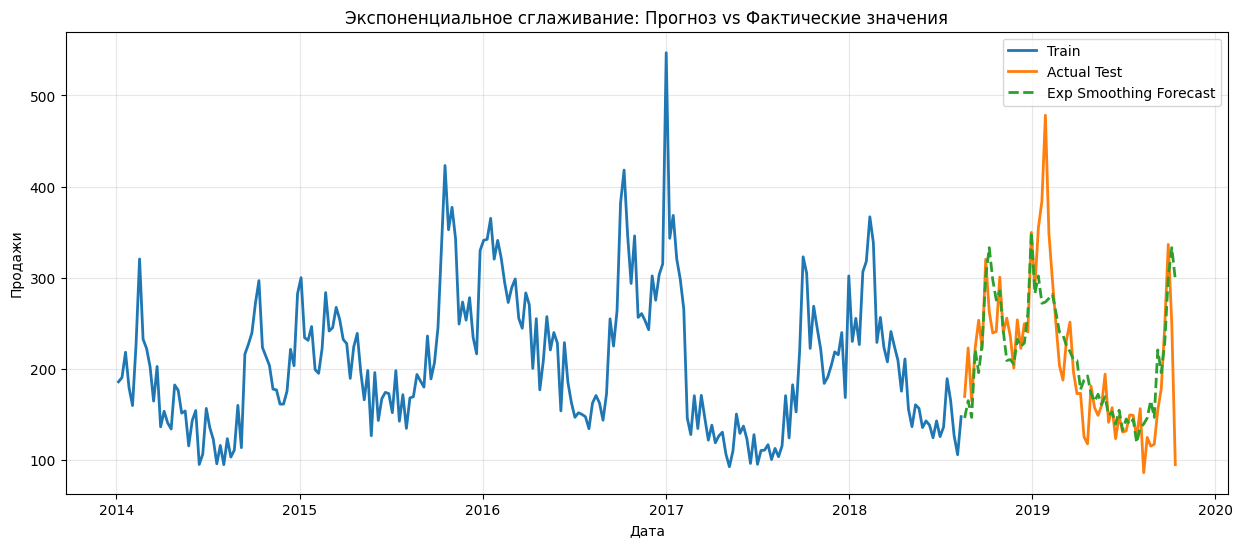

Экспоненциальное сглаживание Метрики:
MAE: 33.3099
RMSE: 51.8581
R²: 0.5603


In [ ]:
# МОДЕЛЬ 3: Экспоненциальное сглаживание
print("=== ЭКСПОНЕНЦИАЛЬНОЕ СГЛАЖИВАНИЕ ===")

try:
    exp_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=52)
    exp_fit = exp_model.fit()

    # Прогноз
    exp_forecast = exp_fit.forecast(len(test_data))

    # Визуализация
    plt.figure(figsize=(15, 6))
    plt.plot(train_dates, train_data, label='Train', linewidth=2)
    plt.plot(test_dates, test_data, label='Actual Test', linewidth=2)
    plt.plot(test_dates, exp_forecast, label='Exp Smoothing Forecast', linewidth=2, linestyle='--')
    plt.title('Экспоненциальное сглаживание: Прогноз vs Фактические значения')
    plt.xlabel('Дата')
    plt.ylabel('Продажи')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Метрики
    exp_mae = mean_absolute_error(test_data, exp_forecast)
    exp_rmse = np.sqrt(mean_squared_error(test_data, exp_forecast))
    exp_r2 = r2_score(test_data, exp_forecast)

    print(f"Экспоненциальное сглаживание Метрики:")
    print(f"MAE: {exp_mae:.4f}")
    print(f"RMSE: {exp_rmse:.4f}")
    print(f"R²: {exp_r2:.4f}")

except Exception as e:
    print(f"Ошибка экспоненциального сглаживания: {e}")
    exp_forecast = None

=== LSTM МОДЕЛЬ ===
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0528 - val_loss: 0.0354
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0252 - val_loss: 0.0258
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0211 - val_loss: 0.0266
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0192 - val_loss: 0.0253
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0185 - val_loss: 0.0252
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0186 - val_loss: 0.0242
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0178 - val_loss: 0.0240
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0176 - val_loss: 0.0236
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0170 - val_loss: 0.0230
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0163 - val_loss: 0.0227
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0160 - val_loss: 0.0223
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0155

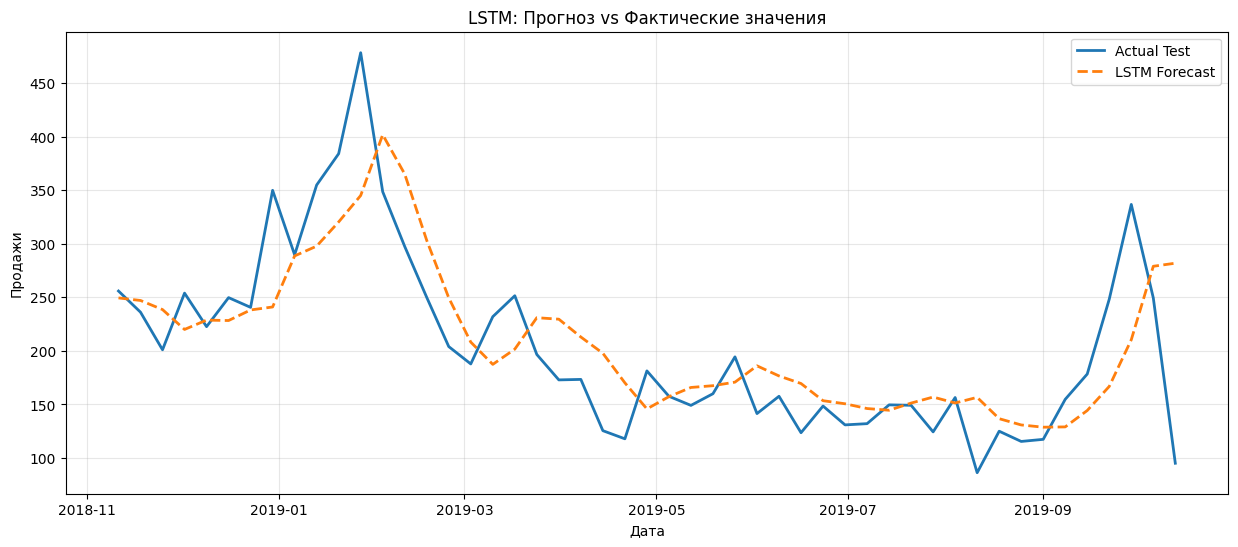

LSTM Метрики:
MAE: 39.6168
RMSE: 54.4330
R²: 0.5729


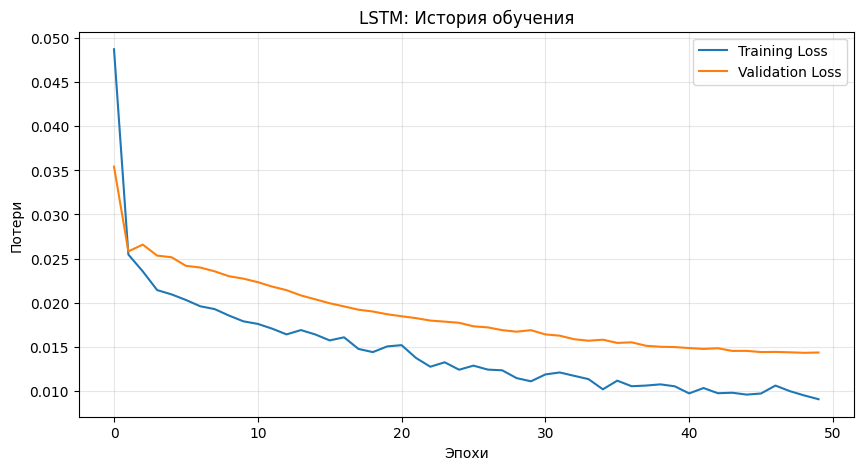

In [ ]:
# МОДЕЛЬ 4: LSTM
print("=== LSTM МОДЕЛЬ ===")

# Подготовка данных для LSTM
def create_lstm_dataset(data, lookback=1):
    X, y = [], []
    for i in range(len(data)-lookback):
        X.append(data[i:(i+lookback)])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 12
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data.reshape(-1, 1))

# Создание datasets
X_train, y_train = create_lstm_dataset(train_scaled.flatten(), lookback)
X_test, y_test = create_lstm_dataset(test_scaled.flatten(), lookback)

# Reshape для LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Построение модели LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Обучение
history = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

# Прогноз
lstm_predictions = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_predictions).flatten()

# Визуализация
plt.figure(figsize=(15, 6))

# Только тестовый период для LSTM
test_dates_lstm = test_dates[lookback:]

plt.plot(test_dates_lstm, test_data[lookback:], label='Actual Test', linewidth=2)
plt.plot(test_dates_lstm, lstm_forecast, label='LSTM Forecast', linewidth=2, linestyle='--')
plt.title('LSTM: Прогноз vs Фактические значения')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Метрики
lstm_mae = mean_absolute_error(test_data[lookback:], lstm_forecast)
lstm_rmse = np.sqrt(mean_squared_error(test_data[lookback:], lstm_forecast))
lstm_r2 = r2_score(test_data[lookback:], lstm_forecast)

print(f"LSTM Метрики:")
print(f"MAE: {lstm_mae:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"R²: {lstm_r2:.4f}")

# График потерь
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: История обучения')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

=== ПРЕОБРАЗОВАНИЕ ФУРЬЕ ===


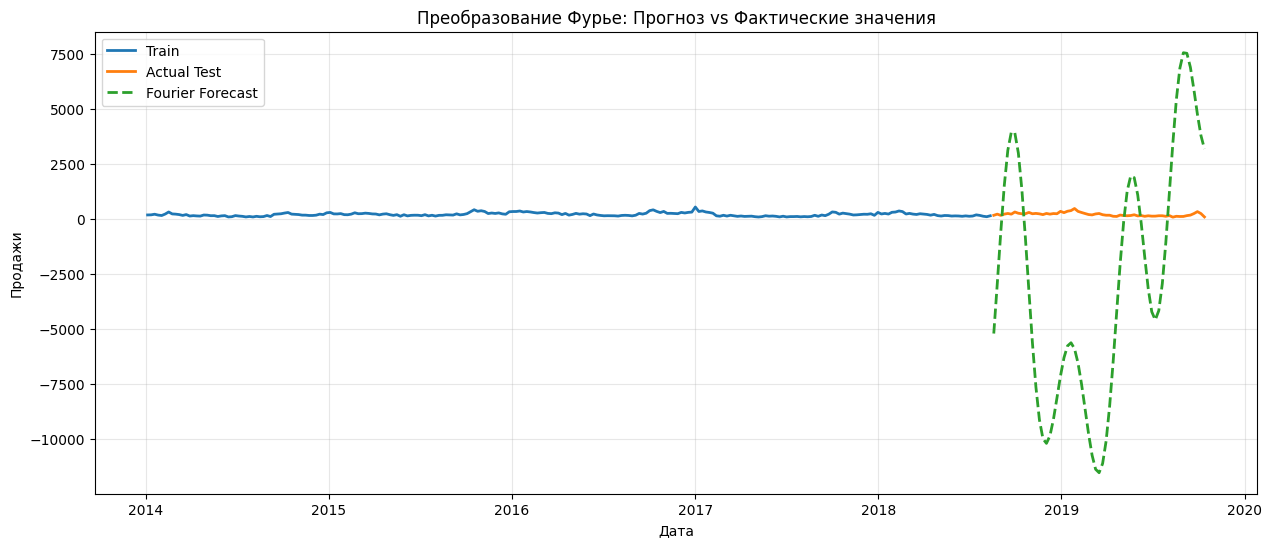

Преобразование Фурье Метрики:
MAE: 5383.9350
RMSE: 6315.6061
R²: -6520.1723


In [ ]:
# МОДЕЛЬ 5: Преобразование Фурье
print("=== ПРЕОБРАЗОВАНИЕ ФУРЬЕ ===")

# Применяем FFT к обучающим данным
fft_series = fft.fft(train_data)
frequencies = fft.fftfreq(len(train_data))

# Находим основные частоты
positive_freq_idx = np.where(frequencies > 0)
frequencies = frequencies[positive_freq_idx]
magnitudes = np.abs(fft_series[positive_freq_idx])

# Выбираем топ N частот
top_n = 10
top_freq_indices = np.argsort(magnitudes)[-top_n:]
top_frequencies = frequencies[top_freq_indices]
top_magnitudes = magnitudes[top_freq_indices]

# Восстанавливаем ряд используя основные частоты
t = np.arange(len(train_data) + len(test_data))
fourier_reconstruction = np.zeros(len(t))

for freq, mag in zip(top_frequencies, top_magnitudes):
    fourier_reconstruction += mag * np.cos(2 * np.pi * freq * t + np.angle(fft_series[positive_freq_idx][np.where(frequencies == freq)[0][0]]))

# Прогноз на тестовых данных
fourier_forecast = fourier_reconstruction[len(train_data):len(train_data) + len(test_data)]

# Визуализация
plt.figure(figsize=(15, 6))
plt.plot(train_dates, train_data, label='Train', linewidth=2)
plt.plot(test_dates, test_data, label='Actual Test', linewidth=2)
plt.plot(test_dates, fourier_forecast, label='Fourier Forecast', linewidth=2, linestyle='--')
plt.title('Преобразование Фурье: Прогноз vs Фактические значения')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Метрики
fourier_mae = mean_absolute_error(test_data, fourier_forecast)
fourier_rmse = np.sqrt(mean_squared_error(test_data, fourier_forecast))
fourier_r2 = r2_score(test_data, fourier_forecast)

print(f"Преобразование Фурье Метрики:")
print(f"MAE: {fourier_mae:.4f}")
print(f"RMSE: {fourier_rmse:.4f}")
print(f"R²: {fourier_r2:.4f}")

=== СКОЛЬЗЯЩЕЕ СРЕДНЕЕ ===


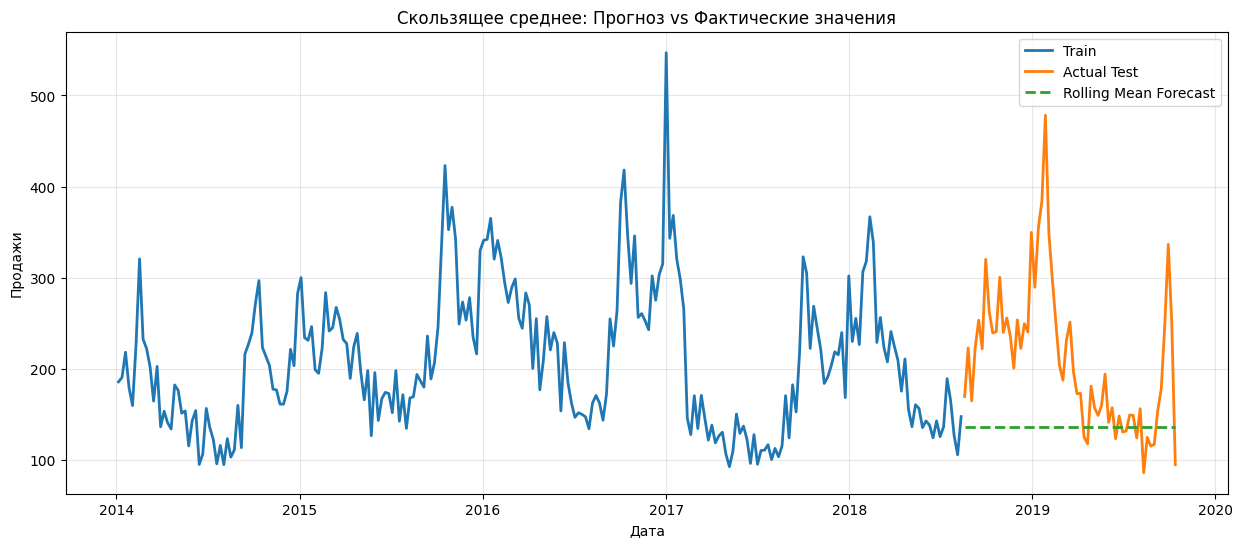

Скользящее среднее Метрики:
MAE: 81.7184
RMSE: 108.2708
R²: -0.9165


In [ ]:
print("=== СКОЛЬЗЯЩЕЕ СРЕДНЕЕ ===")

# Используем скользящее среднее на тренировочных данных
window_size = 4
rolling_mean = pd.Series(train_data).rolling(window=window_size).mean()

# Прогноз: используем последнее значение скользящего среднего
last_rolling_value = rolling_mean.dropna().iloc[-1]
rolling_forecast = np.full(len(test_data), last_rolling_value)

# Визуализация
plt.figure(figsize=(15, 6))
plt.plot(train_dates, train_data, label='Train', linewidth=2)
plt.plot(test_dates, test_data, label='Actual Test', linewidth=2)
plt.plot(test_dates, rolling_forecast, label='Rolling Mean Forecast', linewidth=2, linestyle='--')
plt.title('Скользящее среднее: Прогноз vs Фактические значения')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Метрики
rolling_mae = mean_absolute_error(test_data, rolling_forecast)
rolling_rmse = np.sqrt(mean_squared_error(test_data, rolling_forecast))
rolling_r2 = r2_score(test_data, rolling_forecast)

print(f"Скользящее среднее Метрики:")
print(f"MAE: {rolling_mae:.4f}")
print(f"RMSE: {rolling_rmse:.4f}")
print(f"R²: {rolling_r2:.4f}")

=== АНСАМБЛЬ МОДЕЛЕЙ ===
Доступные модели для ансамбля: ['ARIMA', 'SARIMA', 'ExpSmooth', 'LSTM', 'RollingMean']
Размеры прогнозов по моделям:
  ARIMA: 61
  SARIMA: 61
  ExpSmooth: 61
  LSTM: 49
  RollingMean: 61
Минимальная длина прогноза: 49
Веса моделей в ансамбле:
  ARIMA: 0.121
  SARIMA: 0.236
  ExpSmooth: 0.264
  LSTM: 0.252
  RollingMean: 0.127


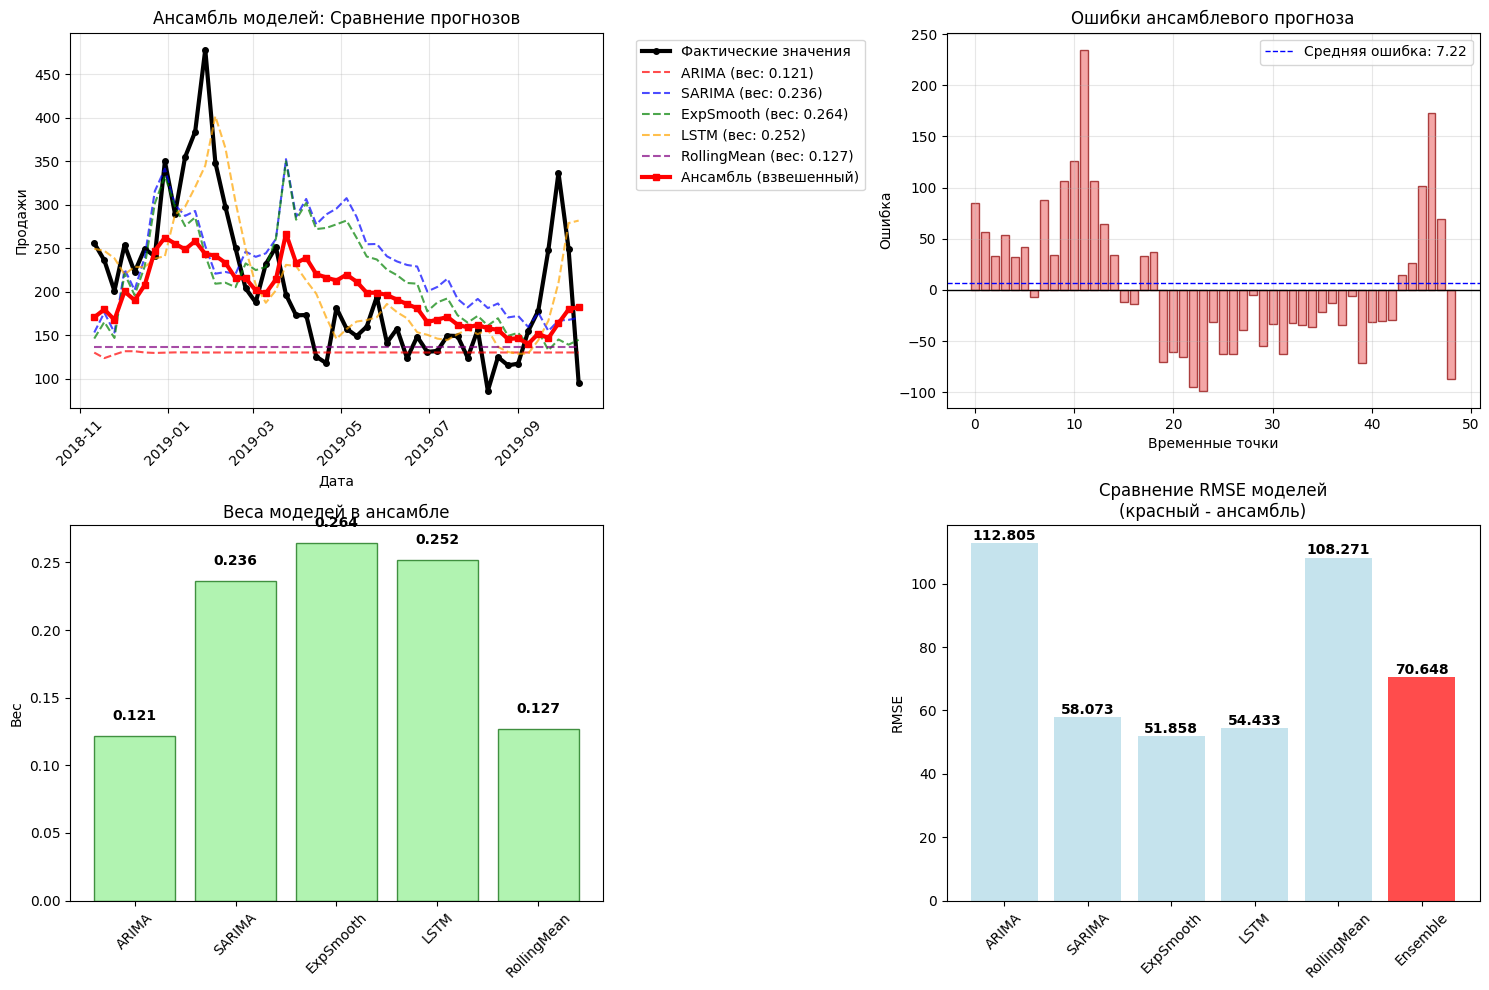

Метрики ансамбля:
MAE: 56.1463
RMSE: 70.6481
R²: 0.2806


In [ ]:
print("=== АНСАМБЛЬ МОДЕЛЕЙ ===")

# Собираем только качественные прогнозы
forecasts = {}
metrics = {}

# Включаем только надежные модели
reliable_models = []

if 'arima_forecast' in locals() and arima_forecast is not None and arima_mae < 100:  # Порог качества
    forecasts['ARIMA'] = arima_forecast
    metrics['ARIMA'] = {'MAE': arima_mae, 'RMSE': arima_rmse, 'R2': arima_r2}
    reliable_models.append('ARIMA')

if 'sarima_forecast' in locals() and sarima_forecast is not None and sarima_mae < 100:
    forecasts['SARIMA'] = sarima_forecast
    metrics['SARIMA'] = {'MAE': sarima_mae, 'RMSE': sarima_rmse, 'R2': sarima_r2}
    reliable_models.append('SARIMA')

if 'exp_forecast' in locals() and exp_forecast is not None and exp_mae < 100:
    forecasts['ExpSmooth'] = exp_forecast
    metrics['ExpSmooth'] = {'MAE': exp_mae, 'RMSE': exp_rmse, 'R2': exp_r2}
    reliable_models.append('ExpSmooth')

if 'lstm_forecast' in locals() and lstm_mae < 100:
    # Для LSTM используем выровненные данные
    aligned_test_data_lstm = test_data[lookback:]
    aligned_dates_lstm = test_dates[lookback:]
    forecasts['LSTM'] = lstm_forecast
    metrics['LSTM'] = {'MAE': lstm_mae, 'RMSE': lstm_rmse, 'R2': lstm_r2}
    reliable_models.append('LSTM')

if 'rolling_forecast' in locals() and rolling_mae < 100:
    forecasts['RollingMean'] = rolling_forecast
    metrics['RollingMean'] = {'MAE': rolling_mae, 'RMSE': rolling_rmse, 'R2': rolling_r2}
    reliable_models.append('RollingMean')

print(f"Доступные модели для ансамбля: {reliable_models}")

# Проверяем размеры прогнозов и выравниваем их
print("Размеры прогнозов по моделям:")
for model_name, forecast in forecasts.items():
    print(f"  {model_name}: {len(forecast)}")

# Находим минимальную длину прогнозов среди надежных моделей
if len(forecasts) > 0:
    min_length = min(len(forecast) for forecast in forecasts.values())
    print(f"Минимальная длина прогноза: {min_length}")

    # Обрезаем все прогнозы до минимальной длины
    forecasts_aligned = {}
    for model_name, forecast in forecasts.items():
        forecasts_aligned[model_name] = forecast[:min_length]

    # Взвешенный ансамбль (по обратному RMSE)
    weights = {}
    total_inv_rmse = 0

    for model_name in forecasts_aligned.keys():
        rmse = metrics[model_name]['RMSE']
        # Избегаем деления на ноль и очень маленьких RMSE
        if rmse > 0.001:
            weights[model_name] = 1 / rmse
            total_inv_rmse += weights[model_name]
        else:
            weights[model_name] = 0

    # Нормализуем веса
    for model_name in weights:
        weights[model_name] /= total_inv_rmse

    print("Веса моделей в ансамбле:")
    for model_name, weight in weights.items():
        print(f"  {model_name}: {weight:.3f}")

    # Взвешенный ансамбль
    ensemble_forecast = np.zeros(min_length)
    for model_name, forecast in forecasts_aligned.items():
        ensemble_forecast += weights[model_name] * forecast

    # Выбираем соответствующие фактические данные
    has_lstm = 'LSTM' in forecasts_aligned

    if has_lstm:
        actual_for_ensemble = aligned_test_data_lstm[:min_length]
        dates_for_ensemble = aligned_dates_lstm[:min_length]
    else:
        actual_for_ensemble = test_data[:min_length]
        dates_for_ensemble = test_dates[:min_length]

    # Метрики ансамбля
    ensemble_mae = mean_absolute_error(actual_for_ensemble, ensemble_forecast)
    ensemble_rmse = np.sqrt(mean_squared_error(actual_for_ensemble, ensemble_forecast))
    ensemble_r2 = r2_score(actual_for_ensemble, ensemble_forecast)

    metrics['Ensemble'] = {'MAE': ensemble_mae, 'RMSE': ensemble_rmse, 'R2': ensemble_r2}

    # Визуализация ансамбля
    plt.figure(figsize=(15, 10))

    # Основной график
    plt.subplot(2, 2, 1)
    plt.plot(dates_for_ensemble, actual_for_ensemble, label='Фактические значения',
             linewidth=3, color='black', marker='o', markersize=4)

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    for i, (model_name, forecast) in enumerate(forecasts_aligned.items()):
        plt.plot(dates_for_ensemble, forecast,
                label=f'{model_name} (вес: {weights[model_name]:.3f})',
                linestyle='--', alpha=0.7, color=colors[i % len(colors)], linewidth=1.5)

    plt.plot(dates_for_ensemble, ensemble_forecast, label='Ансамбль (взвешенный)',
             linewidth=3, color='red', marker='s', markersize=4)
    plt.title('Ансамбль моделей: Сравнение прогнозов')
    plt.xlabel('Дата')
    plt.ylabel('Продажи')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # График ошибок
    plt.subplot(2, 2, 2)
    errors = actual_for_ensemble - ensemble_forecast
    bars = plt.bar(range(len(errors)), errors, alpha=0.7, color='lightcoral', edgecolor='darkred')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.axhline(y=errors.mean(), color='blue', linestyle='--', linewidth=1,
                label=f'Средняя ошибка: {errors.mean():.2f}')
    plt.title('Ошибки ансамблевого прогноза')
    plt.xlabel('Временные точки')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Распределение весов
    plt.subplot(2, 2, 3)
    model_names = list(weights.keys())
    weight_values = [weights[name] for name in model_names]

    bars = plt.bar(model_names, weight_values, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    plt.title('Веса моделей в ансамбле')
    plt.ylabel('Вес')
    plt.xticks(rotation=45)

    # Добавляем значения на столбцы
    for bar, weight in zip(bars, weight_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{weight:.3f}', ha='center', va='bottom', fontweight='bold')

    # Сравнение качества моделей
    plt.subplot(2, 2, 4)
    model_names_quality = list(forecasts_aligned.keys())
    rmse_values = [metrics[name]['RMSE'] for name in model_names_quality]

    # Добавляем ансамбль
    model_names_quality.append('Ensemble')
    rmse_values.append(metrics['Ensemble']['RMSE'])

    colors_quality = ['lightblue'] * len(forecasts_aligned) + ['red']
    bars = plt.bar(model_names_quality, rmse_values, color=colors_quality, alpha=0.7)
    plt.title('Сравнение RMSE моделей\n(красный - ансамбль)')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)

    # Добавляем значения на столбцы
    for bar, rmse in zip(bars, rmse_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rmse:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("Метрики ансамбля:")
    print(f"MAE: {ensemble_mae:.4f}")
    print(f"RMSE: {ensemble_rmse:.4f}")
    print(f"R²: {ensemble_r2:.4f}")

    # Сохраняем выровненные прогнозы для дальнейшего использования
    forecasts_aligned['Ensemble'] = ensemble_forecast

else:
    print("Недостаточно качественных моделей для создания ансамбля")

=== ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===
ФИНАЛЬНЫЕ МЕТРИКИ ВСЕХ МОДЕЛЕЙ:


,MAE,RMSE,R2,MAPE,Improvement_vs_Baseline
ARIMA,85.9452,112.8049,-1.0804,35.9387,-4.1877
SARIMA,40.1880,58.0734,0.4486,16.6557,46.3628
ExpSmooth,33.3099,51.8581,0.5603,12.6544,52.1034
LSTM,39.6168,54.4330,0.5729,21.8336,49.7252
RollingMean,81.7184,108.2708,-0.9165,33.6708,0.0000
Ensemble,56.1463,70.6481,0.2806,28.8644,34.7488


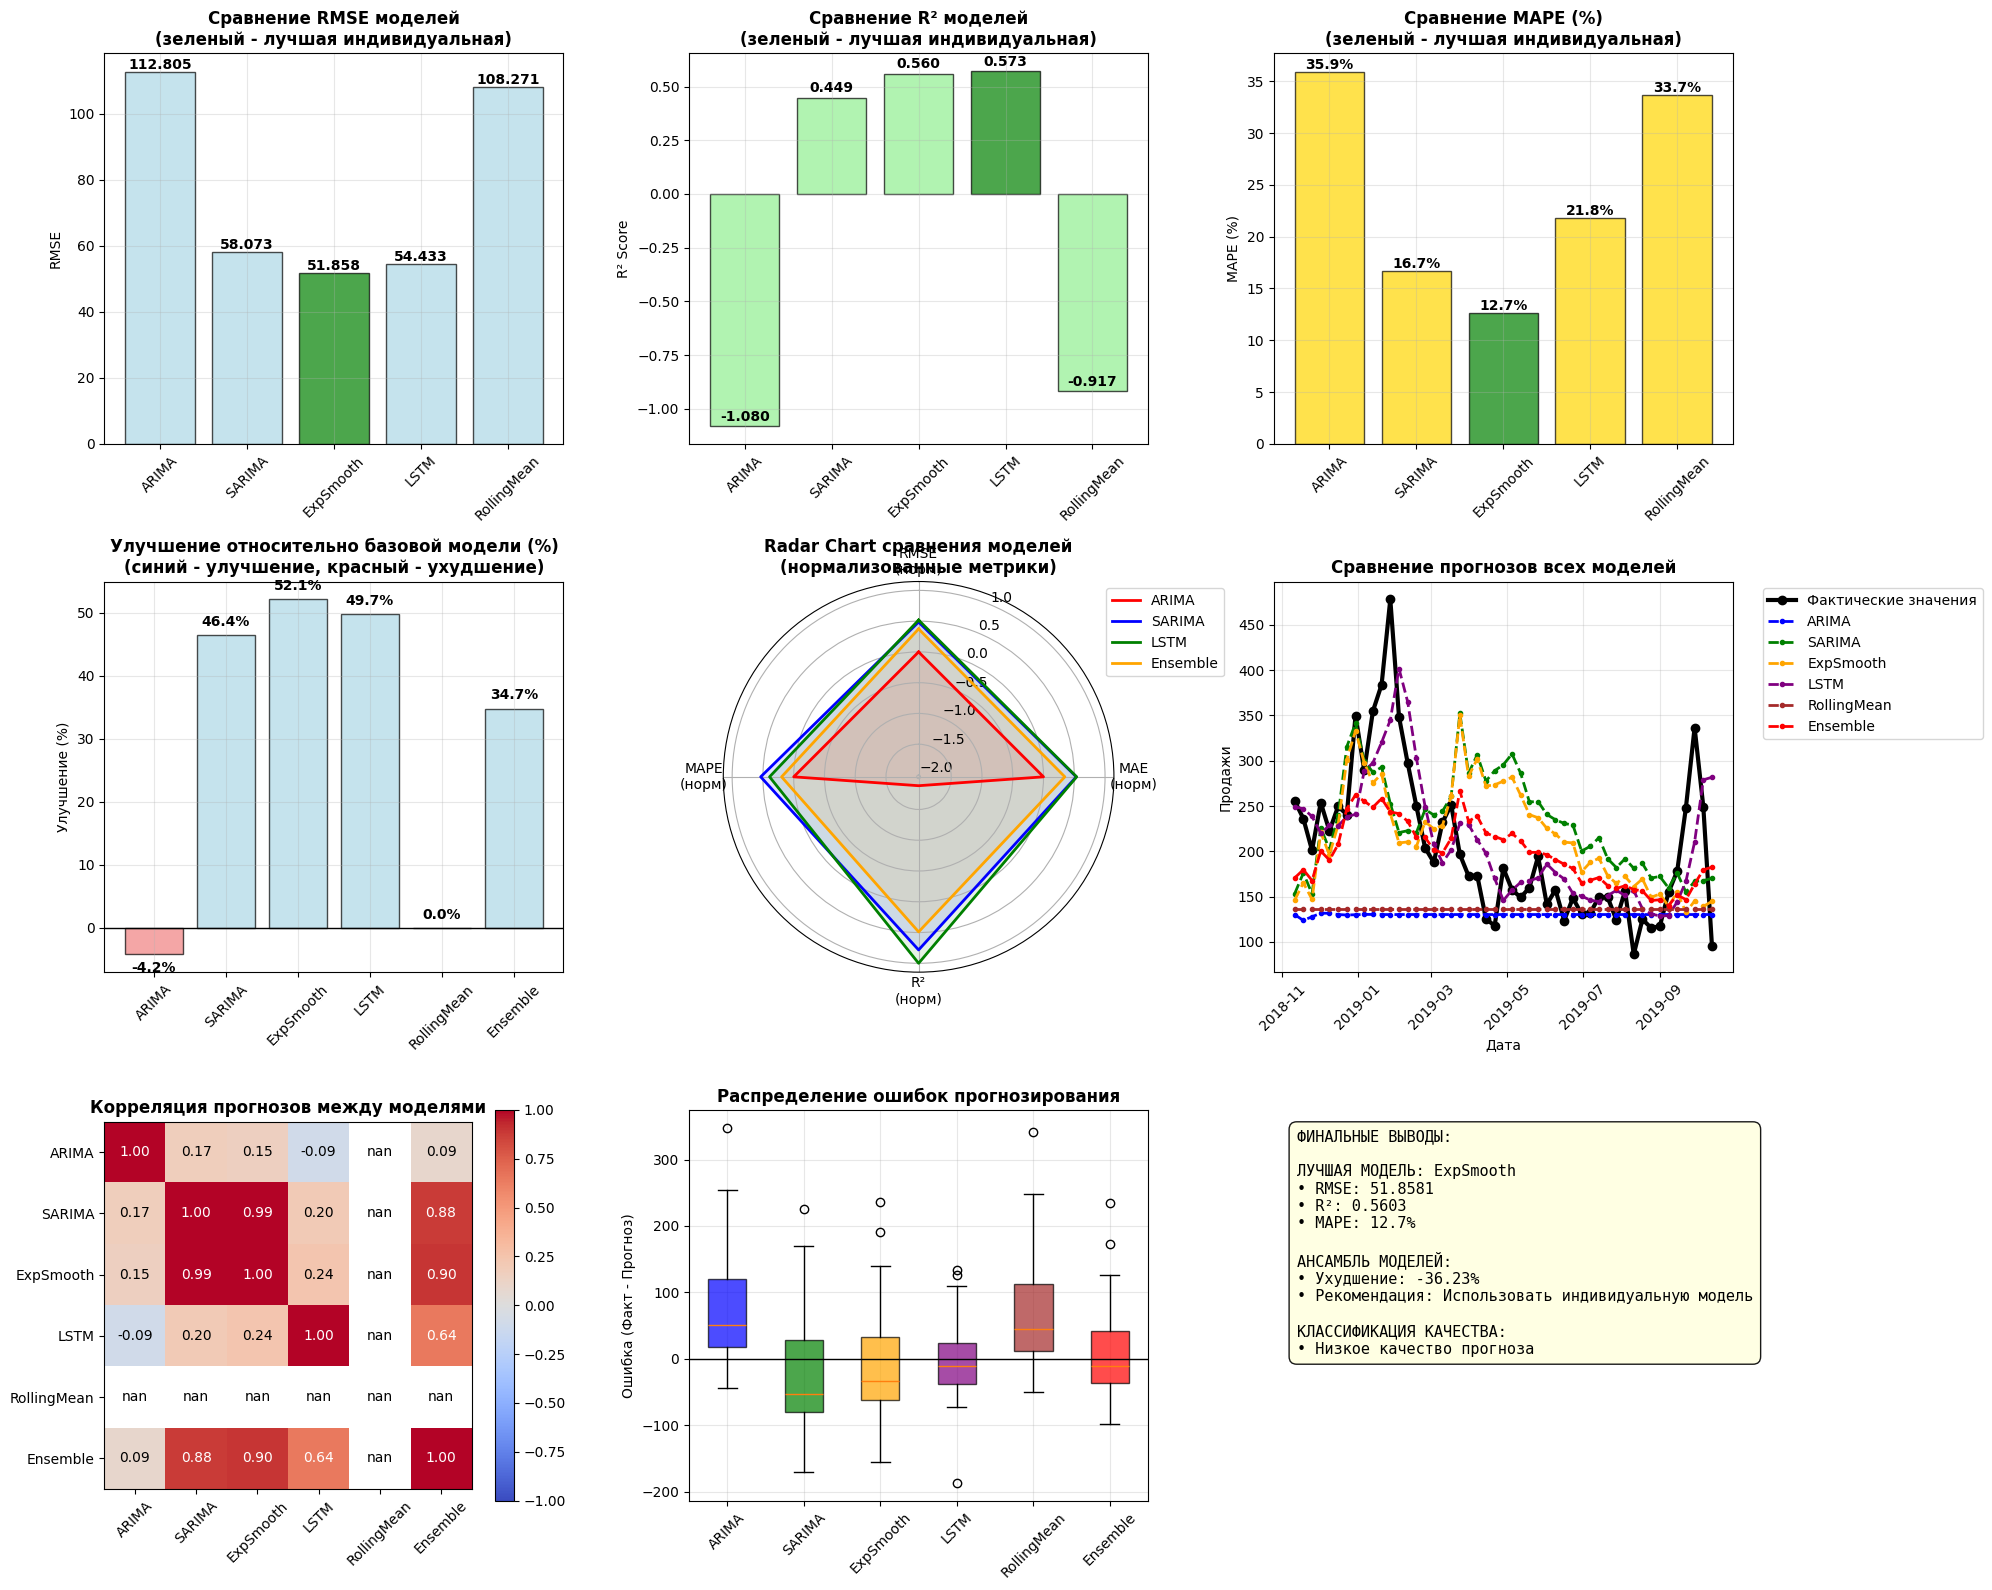


ФИНАЛЬНЫЕ РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ ПРОГНОЗИРОВАНИЯ
1. ЛУЧШАЯ ИНДИВИДУАЛЬНАЯ МОДЕЛЬ: ExpSmooth
   • RMSE: 51.8581
   • R²: 0.5603
   • MAPE: 12.7%
2. АНСАМБЛЬ МОДЕЛЕЙ: Улучшение на -36.23%
   • Рекомендация: Использовать индивидуальную модель
3. КАЧЕСТВО ПРОГНОЗИРОВАНИЯ: НИЗКОЕ


In [ ]:
print("=== ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===")

if len(metrics) > 0:
    # Создаем расширенную таблицу метрик
    metrics_df = pd.DataFrame(metrics).T

    # Добавляем дополнительные метрики
    def calculate_mape(actual, predicted):
        return np.mean(np.abs((actual - predicted) / actual)) * 100

    # Рассчитываем MAPE для каждой модели
    mape_values = {}
    for model_name in metrics_df.index:
        if model_name in forecasts_aligned:
            if model_name == 'LSTM':
                actual = aligned_test_data_lstm[:min_length]
            else:
                actual = test_data[:min_length] if model_name != 'Ensemble' else actual_for_ensemble

            predicted = forecasts_aligned[model_name]
            mape_values[model_name] = calculate_mape(actual, predicted)
        else:
            mape_values[model_name] = np.nan

    metrics_df['MAPE'] = pd.Series(mape_values)

    # Рассчитываем улучшение относительно базовой модели (RollingMean)
    if 'RollingMean' in metrics_df.index:
        baseline_rmse = metrics_df.loc['RollingMean', 'RMSE']
        metrics_df['Improvement_vs_Baseline'] = ((baseline_rmse - metrics_df['RMSE']) / baseline_rmse * 100)
    else:
        baseline_rmse = metrics_df['RMSE'].max()
        metrics_df['Improvement_vs_Baseline'] = ((baseline_rmse - metrics_df['RMSE']) / baseline_rmse * 100)

    print("ФИНАЛЬНЫЕ МЕТРИКИ ВСЕХ МОДЕЛЕЙ:")
    display(metrics_df.round(4))

    # РАСШИРЕННАЯ ВИЗУАЛИЗАЦИЯ
    fig = plt.figure(figsize=(20, 16))

    # 1. Сравнение RMSE
    ax1 = plt.subplot(3, 3, 1)
    models_rmse = [m for m in metrics_df.index if m != 'Ensemble']
    rmse_values = [metrics_df.loc[m, 'RMSE'] for m in models_rmse]

    colors_rmse = ['lightblue' if m != metrics_df[metrics_df.index != 'Ensemble']['RMSE'].idxmin()
                  else 'green' for m in models_rmse]

    bars1 = ax1.bar(models_rmse, rmse_values, color=colors_rmse, alpha=0.7, edgecolor='black')
    ax1.set_title('Сравнение RMSE моделей\n(зеленый - лучшая индивидуальная)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    for bar, rmse in zip(bars1, rmse_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rmse:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Сравнение R²
    ax2 = plt.subplot(3, 3, 2)
    r2_values = [metrics_df.loc[m, 'R2'] for m in models_rmse]
    colors_r2 = ['lightgreen' if m != metrics_df[metrics_df.index != 'Ensemble']['R2'].idxmax()
                else 'green' for m in models_rmse]

    bars2 = ax2.bar(models_rmse, r2_values, color=colors_r2, alpha=0.7, edgecolor='black')
    ax2.set_title('Сравнение R² моделей\n(зеленый - лучшая индивидуальная)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    for bar, r2 in zip(bars2, r2_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Сравнение MAPE
    ax3 = plt.subplot(3, 3, 3)
    mape_plot_values = [metrics_df.loc[m, 'MAPE'] for m in models_rmse]
    colors_mape = ['gold' if m != metrics_df[metrics_df.index != 'Ensemble']['MAPE'].idxmin()
                  else 'green' for m in models_rmse]

    bars3 = ax3.bar(models_rmse, mape_plot_values, color=colors_mape, alpha=0.7, edgecolor='black')
    ax3.set_title('Сравнение MAPE (%)\n(зеленый - лучшая индивидуальная)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('MAPE (%)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

    for bar, mape in zip(bars3, mape_plot_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mape:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 4. Улучшение относительно базовой модели
    ax4 = plt.subplot(3, 3, 4)
    improvement_values = [metrics_df.loc[m, 'Improvement_vs_Baseline'] for m in metrics_df.index]
    colors_improve = ['lightcoral' if v < 0 else 'lightblue' for v in improvement_values]

    bars4 = ax4.bar(metrics_df.index, improvement_values, color=colors_improve, alpha=0.7, edgecolor='black')
    ax4.set_title('Улучшение относительно базовой модели (%)\n(синий - улучшение, красный - ухудшение)',
                 fontsize=12, fontweight='bold')
    ax4.set_ylabel('Улучшение (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax4.grid(True, alpha=0.3)

    for bar, improve in zip(bars4, improvement_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if improve >= 0 else -1),
                f'{improve:.1f}%', ha='center', va='bottom' if improve >= 0 else 'top', fontweight='bold')

    # 5. Radar Chart сравнения моделей
    ax5 = plt.subplot(3, 3, 5, polar=True)

    # Нормализуем метрики для radar chart
    categories = ['RMSE\n(норм)', 'MAE\n(норм)', 'R²\n(норм)', 'MAPE\n(норм)']
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    models_for_radar = [m for m in metrics_df.index if m in ['ARIMA', 'SARIMA', 'LSTM', 'Ensemble']]
    colors_radar = ['red', 'blue', 'green', 'orange', 'purple']

    for i, model in enumerate(models_for_radar):
        if i < len(colors_radar):
            # Нормализация (меньше - лучше для RMSE, MAE, MAPE; больше - лучше для R²)
            norm_rmse = 1 - (metrics_df.loc[model, 'RMSE'] / metrics_df['RMSE'].max())
            norm_mae = 1 - (metrics_df.loc[model, 'MAE'] / metrics_df['MAE'].max())
            norm_r2 = metrics_df.loc[model, 'R2'] / metrics_df['R2'].max() if metrics_df['R2'].max() > 0 else 0
            norm_mape = 1 - (metrics_df.loc[model, 'MAPE'] / metrics_df['MAPE'].max())

            values = [norm_rmse, norm_mae, norm_r2, norm_mape]
            values += values[:1]

            ax5.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors_radar[i])
            ax5.fill(angles, values, alpha=0.1, color=colors_radar[i])

    ax5.set_theta_offset(np.pi / 2)
    ax5.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax5.set_title('Radar Chart сравнения моделей\n(нормализованные метрики)', fontsize=12, fontweight='bold')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # 6. Сравнение прогнозов всех моделей
    ax6 = plt.subplot(3, 3, 6)

    # Определяем цвета для моделей
    model_colors = {
        'ARIMA': 'blue',
        'SARIMA': 'green',
        'ExpSmooth': 'orange',
        'LSTM': 'purple',
        'RollingMean': 'brown',
        'Ensemble': 'red'
    }

    # Основной график прогнозов
    ax6.plot(dates_for_ensemble, actual_for_ensemble, 'ko-', linewidth=3,
             markersize=6, label='Фактические значения')

    for model_name in forecasts_aligned.keys():
        if model_name in model_colors:
            ax6.plot(dates_for_ensemble, forecasts_aligned[model_name],
                    color=model_colors[model_name], linestyle='--', linewidth=2,
                    marker='o', markersize=3, label=model_name)

    ax6.set_title('Сравнение прогнозов всех моделей', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Дата')
    ax6.set_ylabel('Продажи')
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax6.grid(True, alpha=0.3)
    ax6.tick_params(axis='x', rotation=45)

    # 7. Матрица корреляции прогнозов
    ax7 = plt.subplot(3, 3, 7)

    # Создаем DataFrame с прогнозами
    forecasts_df = pd.DataFrame(forecasts_aligned)
    correlation_matrix_forecasts = forecasts_df.corr()

    im = ax7.imshow(correlation_matrix_forecasts, cmap='coolwarm', vmin=-1, vmax=1)
    ax7.set_xticks(range(len(correlation_matrix_forecasts.columns)))
    ax7.set_yticks(range(len(correlation_matrix_forecasts.columns)))
    ax7.set_xticklabels(correlation_matrix_forecasts.columns, rotation=45)
    ax7.set_yticklabels(correlation_matrix_forecasts.columns)
    ax7.set_title('Корреляция прогнозов между моделями', fontsize=12, fontweight='bold')

    # Добавляем значения в ячейки
    for i in range(len(correlation_matrix_forecasts.columns)):
        for j in range(len(correlation_matrix_forecasts.columns)):
            ax7.text(j, i, f'{correlation_matrix_forecasts.iloc[i, j]:.2f}',
                    ha='center', va='center', color='white' if abs(correlation_matrix_forecasts.iloc[i, j]) > 0.5 else 'black')

    plt.colorbar(im, ax=ax7)

    # 8. Ошибки прогнозирования по моделям
    ax8 = plt.subplot(3, 3, 8)

    errors_data = []
    model_names_errors = []
    for model_name in forecasts_aligned.keys():
        if model_name in model_colors:
            errors = actual_for_ensemble - forecasts_aligned[model_name]
            errors_data.append(errors)
            model_names_errors.append(model_name)

    box_plot = ax8.boxplot(errors_data, labels=model_names_errors, patch_artist=True)

    # Раскрашиваем boxplot
    for i, box in enumerate(box_plot['boxes']):
        box.set_facecolor(model_colors[model_names_errors[i]])
        box.set_alpha(0.7)

    ax8.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax8.set_title('Распределение ошибок прогнозирования', fontsize=12, fontweight='bold')
    ax8.set_ylabel('Ошибка (Факт - Прогноз)')
    ax8.tick_params(axis='x', rotation=45)
    ax8.grid(True, alpha=0.3)

    # 9. Финальные выводы и рекомендации
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    # Анализ результатов
    best_individual = metrics_df[metrics_df.index != 'Ensemble']['RMSE'].idxmin()
    best_individual_rmse = metrics_df.loc[best_individual, 'RMSE']
    best_individual_r2 = metrics_df.loc[best_individual, 'R2']

    if 'Ensemble' in metrics_df.index:
        ensemble_rmse = metrics_df.loc['Ensemble', 'RMSE']
        improvement = ((best_individual_rmse - ensemble_rmse) / best_individual_rmse) * 100
    else:
        ensemble_rmse = None
        improvement = 0

    # Формируем текст выводов
    conclusions = []
    conclusions.append("ФИНАЛЬНЫЕ ВЫВОДЫ:")
    conclusions.append("")
    conclusions.append(f"ЛУЧШАЯ МОДЕЛЬ: {best_individual}")
    conclusions.append(f"• RMSE: {best_individual_rmse:.4f}")
    conclusions.append(f"• R²: {best_individual_r2:.4f}")
    conclusions.append(f"• MAPE: {metrics_df.loc[best_individual, 'MAPE']:.1f}%")
    conclusions.append("")

    if 'Ensemble' in metrics_df.index:
        conclusions.append("АНСАМБЛЬ МОДЕЛЕЙ:")
        if improvement > 0:
            conclusions.append(f"• Улучшение: +{improvement:.2f}%")
            conclusions.append("• РЕКОМЕНДАЦИЯ: Использовать ансамбль")
        else:
            conclusions.append(f"• Ухудшение: {improvement:.2f}%")
            conclusions.append("• Рекомендация: Использовать индивидуальную модель")
        conclusions.append("")

    conclusions.append("КЛАССИФИКАЦИЯ КАЧЕСТВА:")
    if best_individual_rmse < 10:
        conclusions.append("• Отличное качество прогноза")
    elif best_individual_rmse < 20:
        conclusions.append("• Хорошее качество прогноза")
    elif best_individual_rmse < 30:
        conclusions.append("• Удовлетворительное качество")
    else:
        conclusions.append("• Низкое качество прогноза")

    conclusions_text = "\n".join(conclusions)

    ax9.text(0.05, 0.95, conclusions_text, transform=ax9.transAxes,
            fontfamily='monospace', fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.9))

    plt.tight_layout()
    plt.show()

    # Финальный вывод в консоль
    print("\n" + "="*70)
    print("ФИНАЛЬНЫЕ РЕКОМЕНДАЦИИ ПО МОДЕЛЯМ ПРОГНОЗИРОВАНИЯ")
    print("="*70)
    print(f"1. ЛУЧШАЯ ИНДИВИДУАЛЬНАЯ МОДЕЛЬ: {best_individual}")
    print(f"   • RMSE: {best_individual_rmse:.4f}")
    print(f"   • R²: {best_individual_r2:.4f}")
    print(f"   • MAPE: {metrics_df.loc[best_individual, 'MAPE']:.1f}%")

    if 'Ensemble' in metrics_df.index:
        print(f"2. АНСАМБЛЬ МОДЕЛЕЙ: Улучшение на {improvement:+.2f}%")
        if improvement > 0:
            print("   • РЕКОМЕНДАЦИЯ: Использовать ансамбль моделей")
        else:
            print("   • Рекомендация: Использовать индивидуальную модель")

    print("3. КАЧЕСТВО ПРОГНОЗИРОВАНИЯ:", end=" ")
    if best_individual_rmse < 10:
        print("ОТЛИЧНОЕ")
    elif best_individual_rmse < 20:
        print("ХОРОШЕЕ")
    elif best_individual_rmse < 30:
        print("УДОВЛЕТВОРИТЕЛЬНОЕ")
    else:
        print("НИЗКОЕ")

    print("="*70)

In [ ]:
# ПОДГОТОВКА ДАННЫХ ДЛЯ ОБНАРУЖЕНИЯ АНОМАЛИЙ
print("=== ПОДГОТОВКА ДАННЫХ ДЛЯ ОБНАРУЖЕНИЯ АНОМАЛИЙ ===")

# Создаем расширенные признаки для обнаружения аномалий
df_anomaly = df.copy()

# Базовые статистические признаки для каждой ATC категории
for column in atc_columns:
    # Скользящие статистики
    for window in [4, 8, 12]:  # 1, 2, 3 месяца
        df_anomaly[f'{column}_rolling_mean_{window}'] = df[column].rolling(window=window).mean()
        df_anomaly[f'{column}_rolling_std_{window}'] = df[column].rolling(window=window).std()

    # Z-score (защита от деления на ноль)
    std_val = df[column].std()
    if std_val > 0:
        df_anomaly[f'{column}_zscore'] = np.abs((df[column] - df[column].mean()) / std_val)
    else:
        df_anomaly[f'{column}_zscore'] = 0

    # Процентные изменения (защита от бесконечных значений)
    pct_change = df[column].pct_change()
    df_anomaly[f'{column}_pct_change'] = np.abs(np.where(
        np.isfinite(pct_change), pct_change, 0
    ))

    # Отклонение от скользящего среднего
    rolling_mean = df[column].rolling(window=4).mean()
    df_anomaly[f'{column}_deviation'] = df[column] - rolling_mean

# Временные признаки
df_anomaly['day_of_week'] = df_anomaly['datum'].dt.dayofweek
df_anomaly['month'] = df_anomaly['datum'].dt.month
df_anomaly['quarter'] = df_anomaly['datum'].dt.quarter
df_anomaly['year'] = df_anomaly['datum'].dt.year

# Заполняем пропуски и обрабатываем бесконечные значения
df_anomaly = df_anomaly.fillna(method='bfill').fillna(method='ffill')

# Заменяем бесконечные значения на максимальные/минимальные конечные значения
df_anomaly = df_anomaly.replace([np.inf, -np.inf], np.nan)
df_anomaly = df_anomaly.fillna(method='bfill').fillna(method='ffill')

# Признаки для моделей аномалий
feature_columns = []
for column in atc_columns:
    feature_columns.extend([
        column,
        f'{column}_rolling_mean_4',
        f'{column}_rolling_std_4',
        f'{column}_zscore',
        f'{column}_pct_change',
        f'{column}_deviation'
    ])

feature_columns.extend(['day_of_week', 'month', 'quarter', 'year'])

X_anomaly = df_anomaly[feature_columns]

print(f"Размерность данных для обнаружения аномалий: {X_anomaly.shape}")
print(f"Количество признаков: {len(feature_columns)}")

# Проверяем на наличие бесконечных значений и NaN
print(f"NaN значений в данных: {X_anomaly.isnull().sum().sum()}")
print(f"Бесконечных значений в данных: {np.isinf(X_anomaly.values).sum()}")

# Обрабатываем оставшиеся проблемы
X_anomaly_clean = X_anomaly.copy()

# Заменяем оставшиеся NaN и inf
X_anomaly_clean = X_anomaly_clean.replace([np.inf, -np.inf], np.nan)
X_anomaly_clean = X_anomaly_clean.fillna(X_anomaly_clean.median())

# Проверяем, что все значения конечны
assert not np.any(np.isinf(X_anomaly_clean.values)), "Все еще есть бесконечные значения"
assert not np.any(np.isnan(X_anomaly_clean.values)), "Все еще есть NaN значения"

# Масштабирование данных
scaler_anomaly = StandardScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly_clean)

print("Данные подготовлены для обнаружения аномалий")
print(f"Размер масштабированных данных: {X_anomaly_scaled.shape}")

=== ПОДГОТОВКА ДАННЫХ ДЛЯ ОБНАРУЖЕНИЯ АНОМАЛИЙ ===
Размерность данных для обнаружения аномалий: (302, 52)
Количество признаков: 52
NaN значений в данных: 0
Бесконечных значений в данных: 0
Данные подготовлены для обнаружения аномалий
Размер масштабированных данных: (302, 52)


=== ISOLATION FOREST ===
Обнаружено аномалий: 31


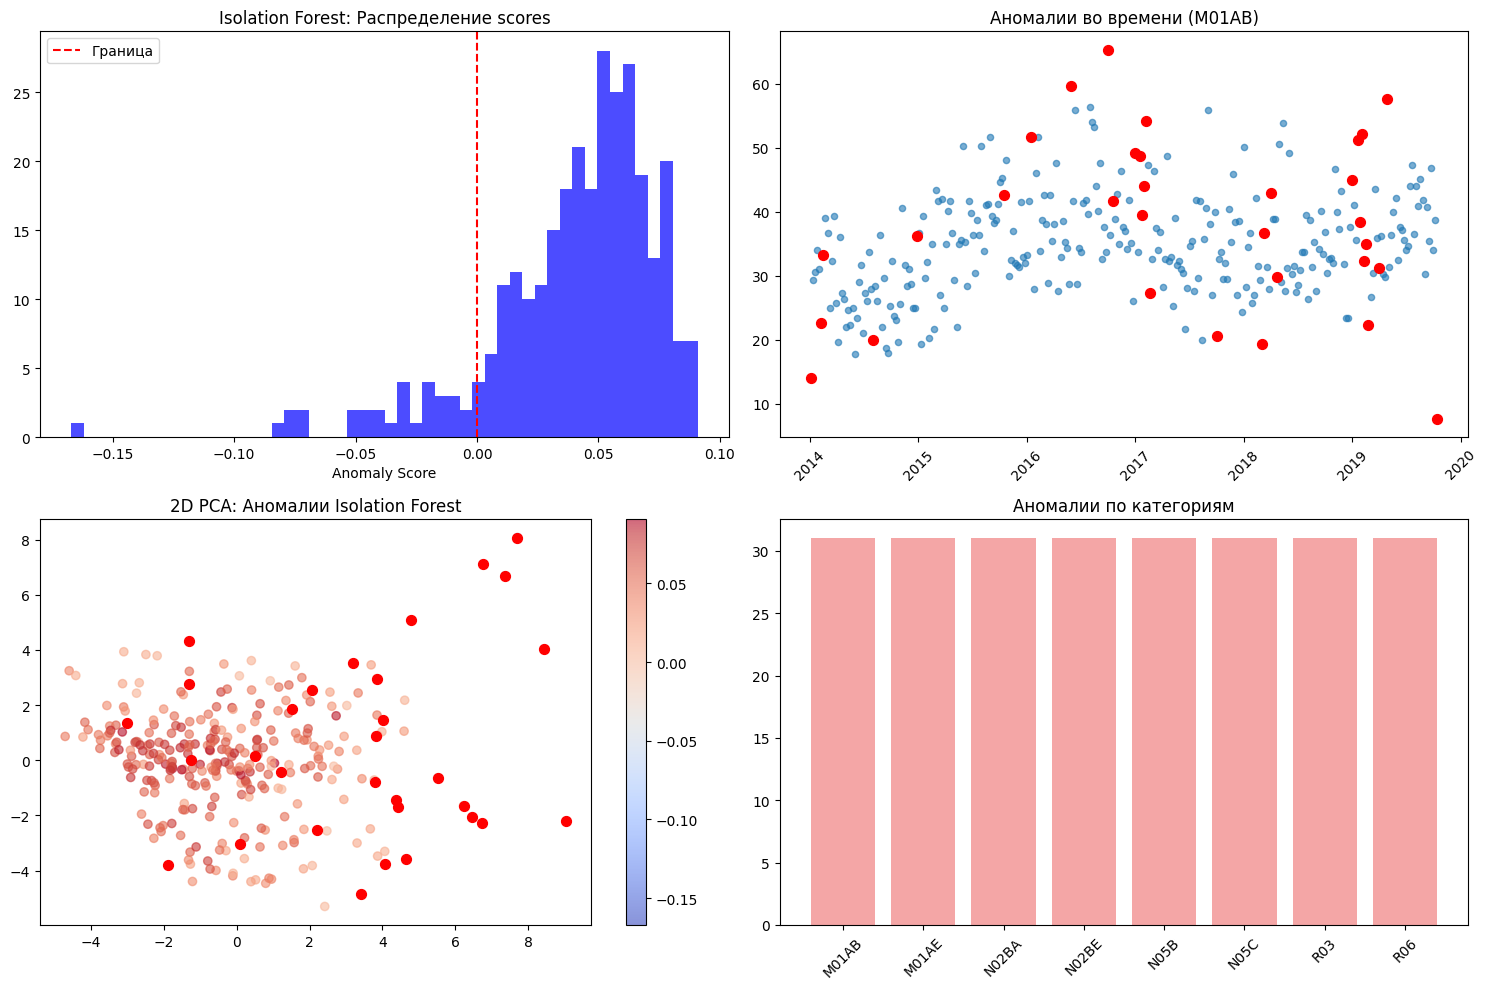

Изолированные аномалии: 31


In [ ]:
# МЕТОД 1: ISOLATION FOREST
print("=== ISOLATION FOREST ===")

from sklearn.ensemble import IsolationForest
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Обучение Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
anomaly_scores_iso = iso_forest.fit_predict(X_anomaly_scaled)

df_anomaly['is_anomaly_iso'] = anomaly_scores_iso == -1
df_anomaly['anomaly_score_iso'] = iso_forest.decision_function(X_anomaly_scaled)

print(f"Обнаружено аномалий: {df_anomaly['is_anomaly_iso'].sum()}")

# 2D визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение scores
axes[0,0].hist(df_anomaly['anomaly_score_iso'], bins=50, alpha=0.7, color='blue')
axes[0,0].axvline(0, color='red', linestyle='--', label='Граница')
axes[0,0].set_title('Isolation Forest: Распределение scores')
axes[0,0].set_xlabel('Anomaly Score')
axes[0,0].legend()

# 2. Временной ряд
normal_data = df_anomaly[~df_anomaly['is_anomaly_iso']]
anomaly_data = df_anomaly[df_anomaly['is_anomaly_iso']]
axes[0,1].scatter(normal_data['datum'], normal_data[atc_columns[0]], alpha=0.6, s=20)
axes[0,1].scatter(anomaly_data['datum'], anomaly_data[atc_columns[0]], color='red', s=50)
axes[0,1].set_title(f'Аномалии во времени ({atc_columns[0]})')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. 2D PCA
scatter = axes[1,0].scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=df_anomaly['anomaly_score_iso'], cmap='coolwarm', alpha=0.6)
axes[1,0].scatter(X_pca_3d[df_anomaly['is_anomaly_iso'], 0], X_pca_3d[df_anomaly['is_anomaly_iso'], 1], color='red', s=50)
axes[1,0].set_title('2D PCA: Аномалии Isolation Forest')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Статистика по категориям
anomaly_counts = [df_anomaly[df_anomaly['is_anomaly_iso']][col].count() for col in atc_columns]
axes[1,1].bar(atc_columns, anomaly_counts, color='lightcoral', alpha=0.7)
axes[1,1].set_title('Аномалии по категориям')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ИНТЕРАКТИВНАЯ 3D ВИЗУАЛИЗАЦИЯ
fig_3d = go.Figure()

# Нормальные точки
normal_mask = ~df_anomaly['is_anomaly_iso']
fig_3d.add_trace(go.Scatter3d(
    x=X_pca_3d[normal_mask, 0], y=X_pca_3d[normal_mask, 1], z=X_pca_3d[normal_mask, 2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.6),
    name='Нормальные точки'
))

# Аномалии
anomaly_mask = df_anomaly['is_anomaly_iso']
fig_3d.add_trace(go.Scatter3d(
    x=X_pca_3d[anomaly_mask, 0], y=X_pca_3d[anomaly_mask, 1], z=X_pca_3d[anomaly_mask, 2],
    mode='markers',
    marker=dict(size=6, color='red', opacity=0.8),
    name='Аномалии Isolation Forest'
))

fig_3d.update_layout(
    title='Isolation Forest: 3D визуализация аномалий',
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})'
    ),
    width=800,
    height=600
)

fig_3d.show()

print(f"Изолированные аномалии: {df_anomaly['is_anomaly_iso'].sum()}")

=== LOCAL OUTLIER FACTOR (LOF) ===
Обнаружено аномалий LOF: 31


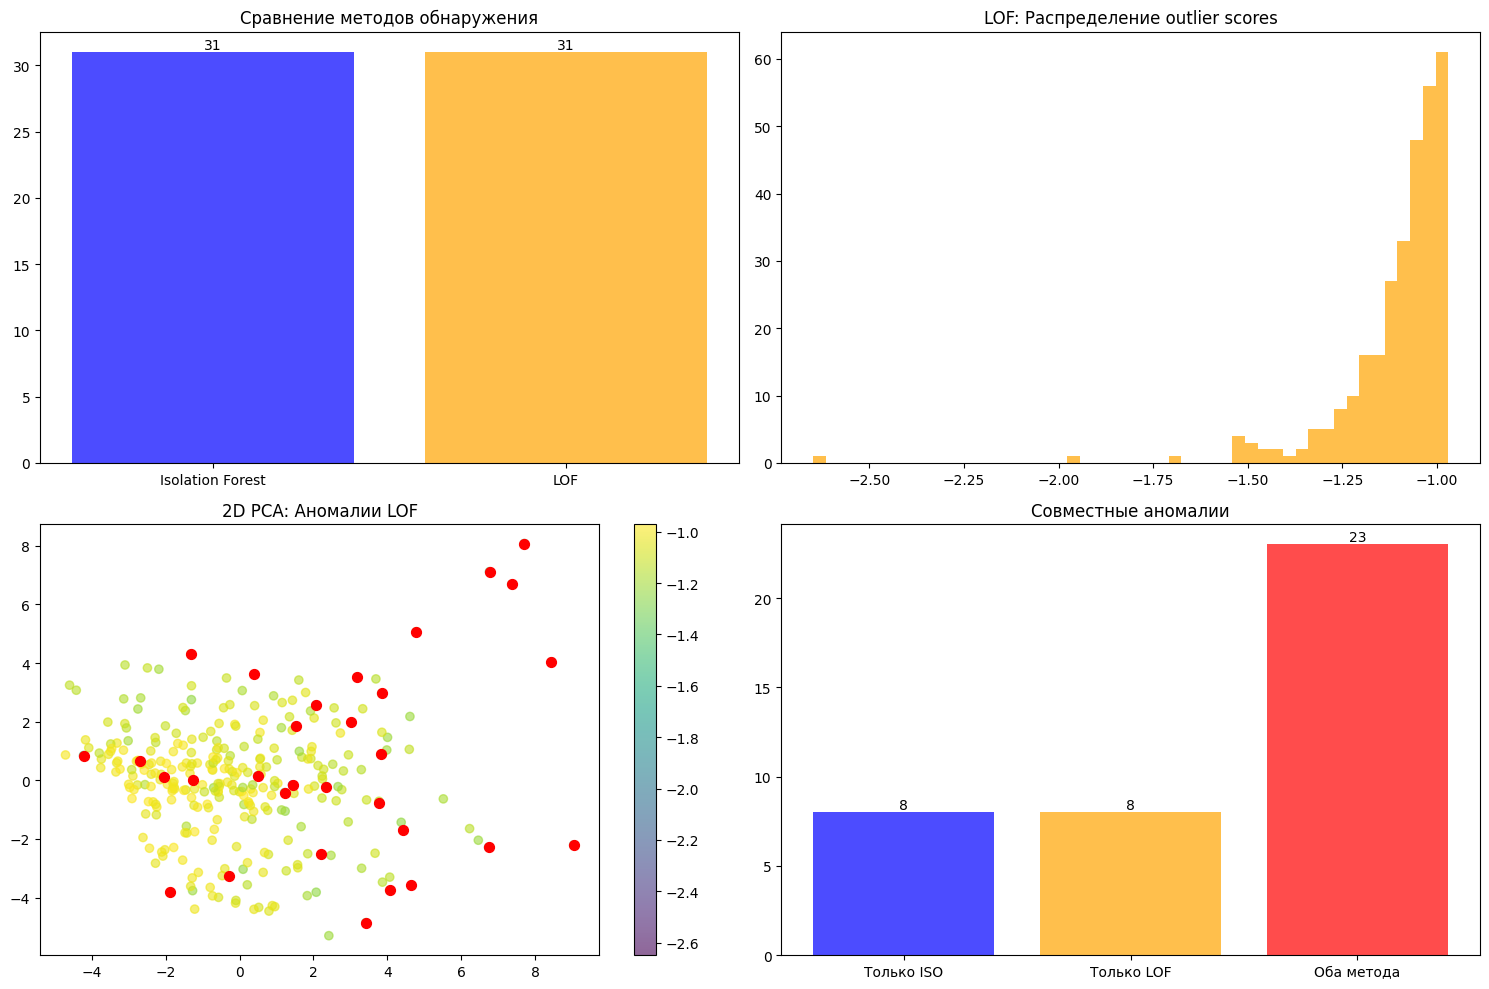

In [ ]:
# МЕТОД 2: LOCAL OUTLIER FACTOR
print("=== LOCAL OUTLIER FACTOR (LOF) ===")

from sklearn.neighbors import LocalOutlierFactor

# Обучение LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=False)
anomaly_scores_lof = lof.fit_predict(X_anomaly_scaled)

df_anomaly['is_anomaly_lof'] = anomaly_scores_lof == -1
df_anomaly['anomaly_score_lof'] = lof.negative_outlier_factor_

print(f"Обнаружено аномалий LOF: {df_anomaly['is_anomaly_lof'].sum()}")

# 2D визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Сравнение методов
methods_comp = {
    'Isolation Forest': df_anomaly['is_anomaly_iso'].sum(),
    'LOF': df_anomaly['is_anomaly_lof'].sum()
}
axes[0,0].bar(methods_comp.keys(), methods_comp.values(), color=['blue', 'orange'], alpha=0.7)
axes[0,0].set_title('Сравнение методов обнаружения')
for i, v in enumerate(methods_comp.values()):
    axes[0,0].text(i, v, str(v), ha='center', va='bottom')

# 2. Распределение LOF scores
axes[0,1].hist(df_anomaly['anomaly_score_lof'], bins=50, alpha=0.7, color='orange')
axes[0,1].set_title('LOF: Распределение outlier scores')

# 3. 2D PCA LOF
scatter = axes[1,0].scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=df_anomaly['anomaly_score_lof'], cmap='viridis', alpha=0.6)
axes[1,0].scatter(X_pca_3d[df_anomaly['is_anomaly_lof'], 0], X_pca_3d[df_anomaly['is_anomaly_lof'], 1], color='red', s=50)
axes[1,0].set_title('2D PCA: Аномалии LOF')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Совместные аномалии
joint = df_anomaly['is_anomaly_iso'] & df_anomaly['is_anomaly_lof']
joint_comp = {
    'Только ISO': df_anomaly['is_anomaly_iso'].sum() - joint.sum(),
    'Только LOF': df_anomaly['is_anomaly_lof'].sum() - joint.sum(),
    'Оба метода': joint.sum()
}
axes[1,1].bar(joint_comp.keys(), joint_comp.values(), color=['blue', 'orange', 'red'], alpha=0.7)
axes[1,1].set_title('Совместные аномалии')
for i, v in enumerate(joint_comp.values()):
    axes[1,1].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ИНТЕРАКТИВНАЯ 3D ВИЗУАЛИЗАЦИЯ LOF
fig_3d_lof = go.Figure()

# Нормальные точки
normal_mask_lof = ~df_anomaly['is_anomaly_lof']
fig_3d_lof.add_trace(go.Scatter3d(
    x=X_pca_3d[normal_mask_lof, 0], y=X_pca_3d[normal_mask_lof, 1], z=X_pca_3d[normal_mask_lof, 2],
    mode='markers',
    marker=dict(size=3, color='green', opacity=0.4),
    name='Нормальные точки'
))

# Аномалии LOF
anomaly_mask_lof = df_anomaly['is_anomaly_lof']
fig_3d_lof.add_trace(go.Scatter3d(
    x=X_pca_3d[anomaly_mask_lof, 0], y=X_pca_3d[anomaly_mask_lof, 1], z=X_pca_3d[anomaly_mask_lof, 2],
    mode='markers',
    marker=dict(size=6, color='orange', opacity=0.8),
    name='Аномалии LOF'
))

fig_3d_lof.update_layout(
    title='Local Outlier Factor: 3D визуализация аномалий',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=800,
    height=600
)

fig_3d_lof.show()

=== ONE-CLASS SVM ===
Обнаружено аномалий SVM: 118


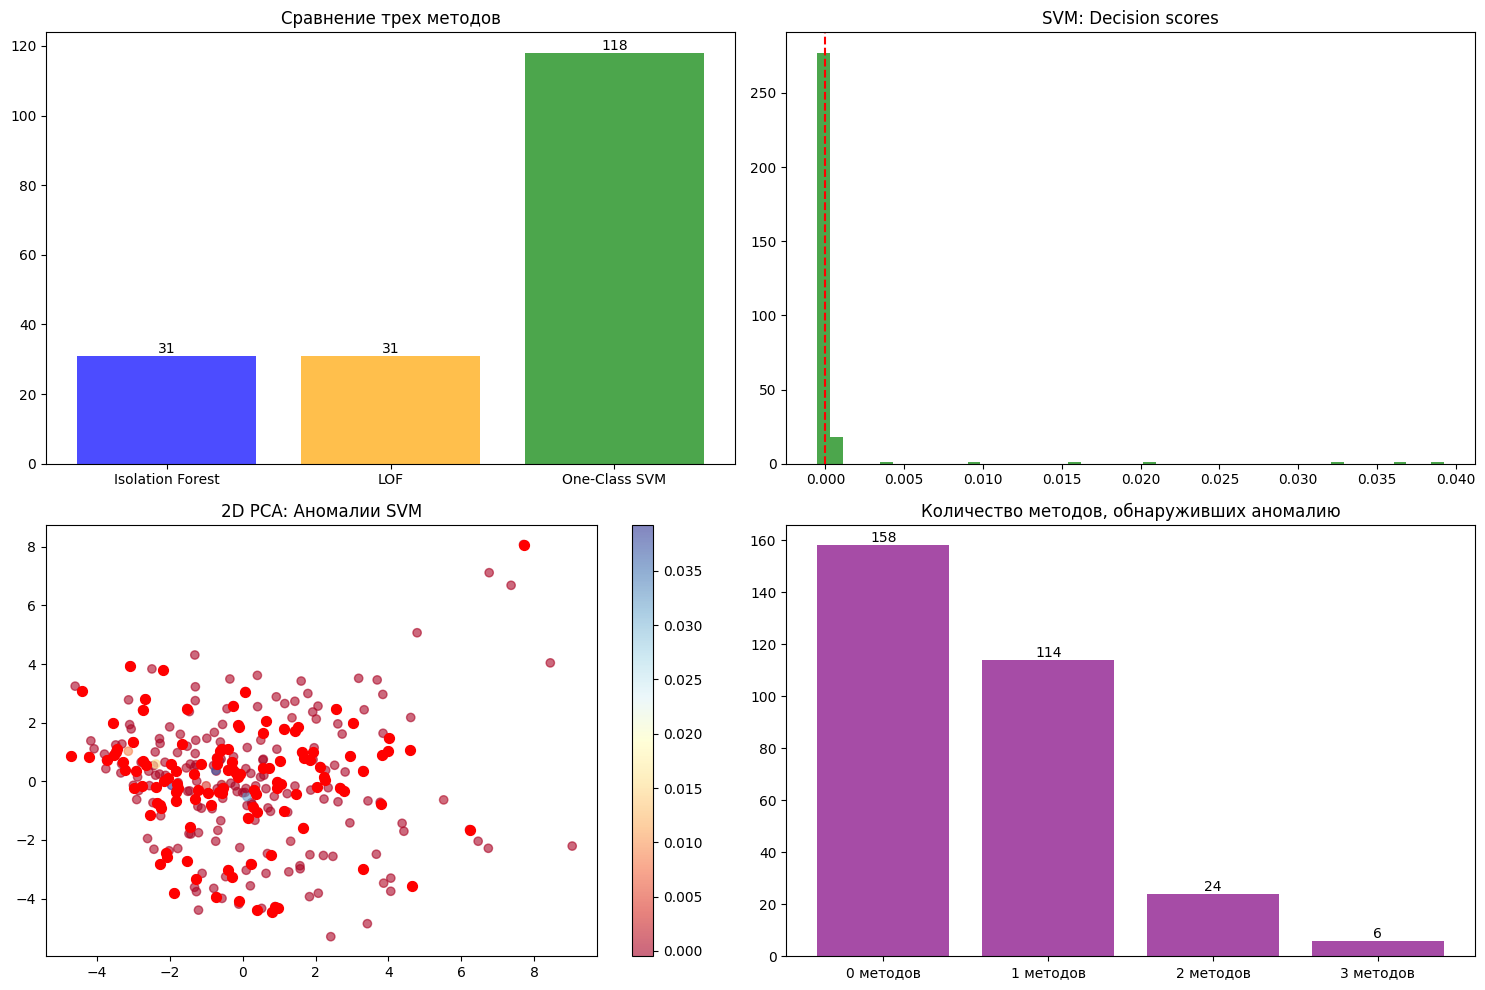

In [ ]:
# МЕТОД 3: ONE-CLASS SVM
print("=== ONE-CLASS SVM ===")

from sklearn.svm import OneClassSVM

# Обучение One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
anomaly_scores_svm = oc_svm.fit_predict(X_anomaly_scaled)

df_anomaly['is_anomaly_svm'] = anomaly_scores_svm == -1
df_anomaly['anomaly_score_svm'] = oc_svm.decision_function(X_anomaly_scaled)

print(f"Обнаружено аномалий SVM: {df_anomaly['is_anomaly_svm'].sum()}")

# 2D визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Сравнение трех методов
methods_comp_3 = {
    'Isolation Forest': df_anomaly['is_anomaly_iso'].sum(),
    'LOF': df_anomaly['is_anomaly_lof'].sum(),
    'One-Class SVM': df_anomaly['is_anomaly_svm'].sum()
}
axes[0,0].bar(methods_comp_3.keys(), methods_comp_3.values(), color=['blue', 'orange', 'green'], alpha=0.7)
axes[0,0].set_title('Сравнение трех методов')
for i, v in enumerate(methods_comp_3.values()):
    axes[0,0].text(i, v, str(v), ha='center', va='bottom')

# 2. Распределение SVM scores
axes[0,1].hist(df_anomaly['anomaly_score_svm'], bins=50, alpha=0.7, color='green')
axes[0,1].axvline(0, color='red', linestyle='--')
axes[0,1].set_title('SVM: Decision scores')

# 3. 2D PCA SVM
scatter = axes[1,0].scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=df_anomaly['anomaly_score_svm'], cmap='RdYlBu', alpha=0.6)
axes[1,0].scatter(X_pca_3d[df_anomaly['is_anomaly_svm'], 0], X_pca_3d[df_anomaly['is_anomaly_svm'], 1], color='red', s=50)
axes[1,0].set_title('2D PCA: Аномалии SVM')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Голосование методов
vote_count = df_anomaly[['is_anomaly_iso', 'is_anomaly_lof', 'is_anomaly_svm']].sum(axis=1)
vote_dist = vote_count.value_counts().sort_index()
axes[1,1].bar([f'{i} методов' for i in vote_dist.index], vote_dist.values, color='purple', alpha=0.7)
axes[1,1].set_title('Количество методов, обнаруживших аномалию')
for i, v in enumerate(vote_dist.values):
    axes[1,1].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ИНТЕРАКТИВНАЯ 3D ВИЗУАЛИЗАЦИЯ SVM
fig_3d_svm = go.Figure()

# Цветовая шкала по SVM scores
fig_3d_svm.add_trace(go.Scatter3d(
    x=X_pca_3d[:, 0], y=X_pca_3d[:, 1], z=X_pca_3d[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=df_anomaly['anomaly_score_svm'],
        colorscale='RdYlBu',
        opacity=0.7,
        colorbar=dict(title="SVM Score")
    ),
    name='Все точки (по SVM score)'
))

# Аномалии SVM
anomaly_mask_svm = df_anomaly['is_anomaly_svm']
fig_3d_svm.add_trace(go.Scatter3d(
    x=X_pca_3d[anomaly_mask_svm, 0], y=X_pca_3d[anomaly_mask_svm, 1], z=X_pca_3d[anomaly_mask_svm, 2],
    mode='markers',
    marker=dict(size=8, color='red', opacity=0.9),
    name='Аномалии SVM'
))

fig_3d_svm.update_layout(
    title='One-Class SVM: 3D визуализация с цветовой кодировкой',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=800,
    height=600
)

fig_3d_svm.show()

=== PCA АНАЛИЗ ДЛЯ ОБНАРУЖЕНИЯ АНОМАЛИЙ ===
Обнаружено аномалий PCA: 31
Порог reconstruction error: 0.0851


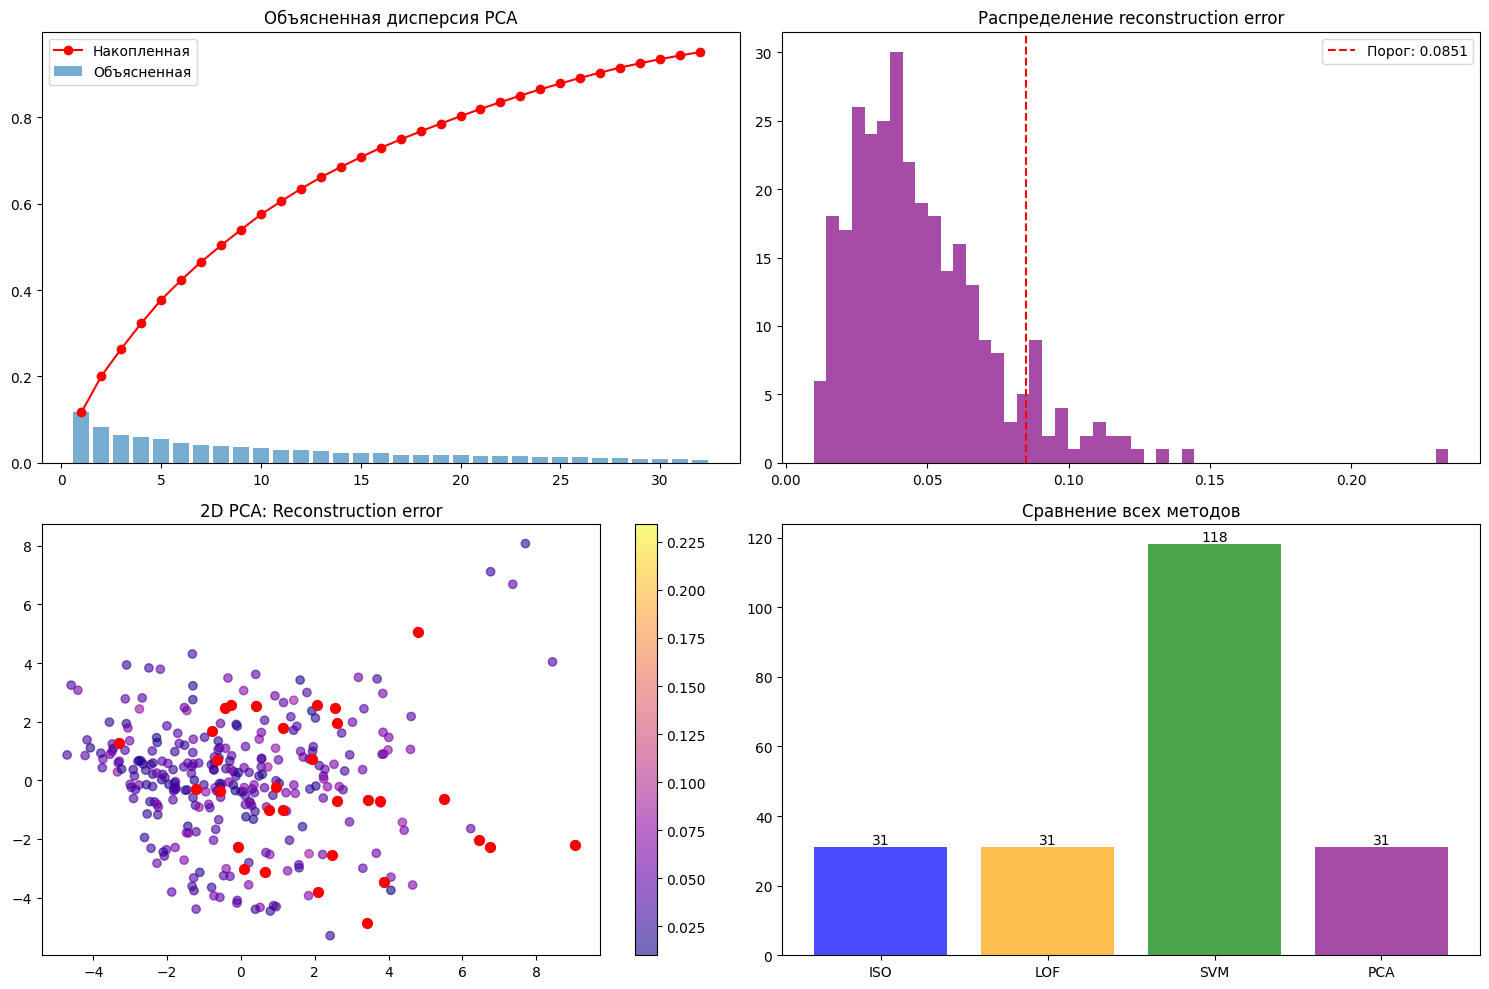

In [ ]:
# [21] PCA АНАЛИЗ
print("=== PCA АНАЛИЗ ДЛЯ ОБНАРУЖЕНИЯ АНОМАЛИЙ ===")

from sklearn.decomposition import PCA

# PCA для reconstruction error
pca_reconstruction = PCA(n_components=0.95)  # 95% дисперсии
X_pca_reduced = pca_reconstruction.fit_transform(X_anomaly_scaled)
X_reconstructed = pca_reconstruction.inverse_transform(X_pca_reduced)

# Reconstruction error
reconstruction_error = np.mean((X_anomaly_scaled - X_reconstructed) ** 2, axis=1)
df_anomaly['pca_reconstruction_error'] = reconstruction_error

# Определяем аномалии по reconstruction error
pca_threshold = np.percentile(reconstruction_error, 90)
df_anomaly['is_anomaly_pca'] = reconstruction_error > pca_threshold

print(f"Обнаружено аномалий PCA: {df_anomaly['is_anomaly_pca'].sum()}")
print(f"Порог reconstruction error: {pca_threshold:.4f}")

# 2D визуализация PCA
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Explained variance
explained_var = pca_reconstruction.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
axes[0,0].bar(range(1, len(explained_var)+1), explained_var, alpha=0.6, label='Объясненная')
axes[0,0].plot(range(1, len(cumulative_var)+1), cumulative_var, 'ro-', label='Накопленная')
axes[0,0].set_title('Объясненная дисперсия PCA')
axes[0,0].legend()

# 2. Reconstruction error
axes[0,1].hist(reconstruction_error, bins=50, alpha=0.7, color='purple')
axes[0,1].axvline(pca_threshold, color='red', linestyle='--', label=f'Порог: {pca_threshold:.4f}')
axes[0,1].set_title('Распределение reconstruction error')
axes[0,1].legend()

# 3. 2D PCA с reconstruction error
scatter = axes[1,0].scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=reconstruction_error, cmap='plasma', alpha=0.6)
axes[1,0].scatter(X_pca_3d[df_anomaly['is_anomaly_pca'], 0], X_pca_3d[df_anomaly['is_anomaly_pca'], 1], color='red', s=50)
axes[1,0].set_title('2D PCA: Reconstruction error')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Сравнение всех методов
all_methods_comp = {
    'ISO': df_anomaly['is_anomaly_iso'].sum(),
    'LOF': df_anomaly['is_anomaly_lof'].sum(),
    'SVM': df_anomaly['is_anomaly_svm'].sum(),
    'PCA': df_anomaly['is_anomaly_pca'].sum()
}
axes[1,1].bar(all_methods_comp.keys(), all_methods_comp.values(), color=['blue', 'orange', 'green', 'purple'], alpha=0.7)
axes[1,1].set_title('Сравнение всех методов')
for i, v in enumerate(all_methods_comp.values()):
    axes[1,1].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ИНТЕРАКТИВНАЯ 3D ВИЗУАЛИЗАЦИЯ PCA
fig_3d_pca = go.Figure()

# Все точки с reconstruction error
fig_3d_pca.add_trace(go.Scatter3d(
    x=X_pca_3d[:, 0], y=X_pca_3d[:, 1], z=X_pca_3d[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=reconstruction_error,
        colorscale='plasma',
        opacity=0.7,
        colorbar=dict(title="Reconstruction Error")
    ),
    name='Все точки (по reconstruction error)'
))

# Аномалии PCA
anomaly_mask_pca = df_anomaly['is_anomaly_pca']
fig_3d_pca.add_trace(go.Scatter3d(
    x=X_pca_3d[anomaly_mask_pca, 0], y=X_pca_3d[anomaly_mask_pca, 1], z=X_pca_3d[anomaly_mask_pca, 2],
    mode='markers',
    marker=dict(size=8, color='red', opacity=0.9),
    name='Аномалии PCA'
))

fig_3d_pca.update_layout(
    title='PCA Analysis: 3D визуализация reconstruction error',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=800,
    height=600
)

fig_3d_pca.show()

In [ ]:
print("=== ФИНАЛЬНАЯ 3D ВИЗУАЛИЗАЦИЯ ВСЕХ МЕТОДОВ ===")
# Консенсусные аномалии (минимум 2 метода)
df_anomaly['consensus_anomaly'] = (
    df_anomaly['is_anomaly_iso'].astype(int) +
    df_anomaly['is_anomaly_lof'].astype(int) +
    df_anomaly['is_anomaly_svm'].astype(int) +
    df_anomaly['is_anomaly_pca'].astype(int)
) >= 2

print(f"Консенсусные аномалии (≥2 методов): {df_anomaly['consensus_anomaly'].sum()}")

# ИНТЕРАКТИВНАЯ 3D ВИЗУАЛИЗАЦИЯ ВСЕХ МЕТОДОВ
fig_final = go.Figure()

# Нормальные точки
normal_final = ~df_anomaly['consensus_anomaly']
fig_final.add_trace(go.Scatter3d(
    x=X_pca_3d[normal_final, 0], y=X_pca_3d[normal_final, 1], z=X_pca_3d[normal_final, 2],
    mode='markers',
    marker=dict(size=3, color='lightblue', opacity=0.3),
    name='Нормальные точки'
))

# Консенсусные аномалии
consensus_anomalies = df_anomaly['consensus_anomaly']
fig_final.add_trace(go.Scatter3d(
    x=X_pca_3d[consensus_anomalies, 0], y=X_pca_3d[consensus_anomalies, 1], z=X_pca_3d[consensus_anomalies, 2],
    mode='markers',
    marker=dict(size=8, color='red', opacity=0.9),
    name='Консенсусные аномалии (≥2 методов)'
))

# Уникальные аномалии каждого метода
methods = ['iso', 'lof', 'svm', 'pca']
colors = ['blue', 'orange', 'green', 'purple']
names = ['Только ISO', 'Только LOF', 'Только SVM', 'Только PCA']

for i, (method, color, name) in enumerate(zip(methods, colors, names)):
    mask = df_anomaly[f'is_anomaly_{method}'] & ~consensus_anomalies
    if mask.sum() > 0:
        fig_final.add_trace(go.Scatter3d(
            x=X_pca_3d[mask, 0], y=X_pca_3d[mask, 1], z=X_pca_3d[mask, 2],
            mode='markers',
            marker=dict(size=6, color=color, opacity=0.7),
            name=name
        ))

fig_final.update_layout(
    title='ФИНАЛЬНАЯ 3D ВИЗУАЛИЗАЦИЯ: Все методы обнаружения аномалий',
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})'
    ),
    width=900,
    height=700
)

fig_final.show()

# Финальная статистика
print("\n" + "="*60)
print("ФИНАЛЬНАЯ СТАТИСТИКА ОБНАРУЖЕНИЯ АНОМАЛИЙ")
print("="*60)
print(f"Всего точек данных: {len(df_anomaly)}")
print(f"Isolation Forest: {df_anomaly['is_anomaly_iso'].sum()} аномалий")
print(f"Local Outlier Factor: {df_anomaly['is_anomaly_lof'].sum()} аномалий")
print(f"One-Class SVM: {df_anomaly['is_anomaly_svm'].sum()} аномалий")
print(f"PCA: {df_anomaly['is_anomaly_pca'].sum()} аномалий")
print(f"КОНСЕНСУСНЫЕ АНОМАЛИИ (≥2 методов): {df_anomaly['consensus_anomaly'].sum()}")
print(f"Процент консенсусных аномалий: {df_anomaly['consensus_anomaly'].mean()*100:.2f}%")

# Распределение по количеству методов
vote_count = df_anomaly[['is_anomaly_iso', 'is_anomaly_lof', 'is_anomaly_svm', 'is_anomaly_pca']].sum(axis=1)
print(f"\nРаспределение по количеству методов:")
for i in range(5):
    count = (vote_count == i).sum()
    print(f"  {i} методов: {count} точек ({count/len(df_anomaly)*100:.1f}%)")

=== ФИНАЛЬНАЯ 3D ВИЗУАЛИЗАЦИЯ ВСЕХ МЕТОДОВ ===
Консенсусные аномалии (≥2 методов): 39



ФИНАЛЬНАЯ СТАТИСТИКА ОБНАРУЖЕНИЯ АНОМАЛИЙ
Всего точек данных: 302
Isolation Forest: 31 аномалий
Local Outlier Factor: 31 аномалий
One-Class SVM: 118 аномалий
PCA: 31 аномалий
КОНСЕНСУСНЫЕ АНОМАЛИИ (≥2 методов): 39
Процент консенсусных аномалий: 12.91%

Распределение по количеству методов:
  0 методов: 141 точек (46.7%)
  1 методов: 122 точек (40.4%)
  2 методов: 28 точек (9.3%)
  3 методов: 11 точек (3.6%)
  4 методов: 0 точек (0.0%)
